In [1]:
import pandas as pd
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.animation as animation
from collections import defaultdict
from IPython.display import HTML
import matplotlib.patches as patches
import copy
import cv2

# Prepare boxes axiall full

In [2]:
coordinates_data = pd.read_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates_data.pkl")
#boxes_axial = coordinates_data[coordinates_data.series_description == 'Axial T2']
#boxes_axial.head()

In [3]:
class Condition():
    def __init__(self, condition, status, location, instance, depth, p_position):
        self.condition_name = condition
        self.status = status
        self.misplaced = False
        self.wrong_instance = False
        
        if pd.isna(status):
            self.status = 'Unknown'
        self.instance = instance
        self.location = location
        self.depth = depth
        self.pposition = p_position

    def get_box(self, overhead:list[float, float, float, float]=[0., 0., 0., 0.], type='pascal_voc', im_width:int=1200, im_height:int=1200):
         return [max(0, self.location[0]-overhead[0]), 
                           max(0, self.location[1]-overhead[1]), 
                           min(im_width, self.location[0]+overhead[2]), 
                           min(im_height, self.location[1]+overhead[3])]

Plan to (automaticaly) fix sagittals:  
- Try to fix wrong coordinates by hand for one slide and translate it to the rest (for wrongly unified sagittals)
- Try to adjust left and right foramina to the same location as the other foramina (for shifted sagittals) 
    -- additionaly try to choose the one that does not align with spinal canale (for united series)

In [4]:
class Level():
    def __init__(self, level:pd.DataFrame):
        self.study_id = level.iloc[0].study_id
        self.series_id = level.iloc[0].series_id
        self.im_width = level.iloc[0].image_width
        self.im_height = level.iloc[0].image_height
        self.pixel_spacing = level.iloc[0].pixel_spacing

        self.level_ind = level.iloc[0].level
        self.all_instances = level.iloc[0].present_instances
        self.all_depths = level.iloc[0].slice_locations
        self.all_ipp= level.iloc[0].ImagePositionPatient

        self.instances = None
        self.depths = None
        self.reversed = False
        
        self.level_names = {'L1/L2': 0, 'L2/L3': 1, 'L3/L4': 2, 'L4/L5': 3, 'L5/S1':4}

        self.condition_list = [
            'Left Neural Foraminal Narrowing',
            'Left Subarticular Stenosis',
            'Right Neural Foraminal Narrowing',
            'Right Subarticular Stenosis',
            'Spinal Canal Stenosis']
        
        self.status_map = {'Normal/Mild': [1., 0., 0.],
                            'Moderate': [0., 1., 0.],
                            'Severe': [0., 0., 1.]}
        
        self.error_codes = {
            'Repeating conditions': False,
            'Missing conditions': False,
            'Conditions misaligned': False,
            'depths misaligned' : False,
        }
        
        self.fix_codes = {
            'Unknown status': False,
            'User-resolved depth': False,
            'Auto-resolved depth': False,
            'User-resolved coordinates': False,
            'Auto-resolved coordinates': False,
            'combined': False,
            'stitched': False
        }
        
        self.fully_annoted = False
        self.conditions  = self.get_conditions(level)
        self.get_instances()
        
        self.level_box = None
        self.create_instance_box()
        self.diagnose_log = []

        self.unified = False
    
    def condition(self, cond_name:str):
        return next((c for c in self.conditions if c.condition_name == cond_name), None)
    
    def get_conditions(self, level:pd.DataFrame):
        present_conditions = []
        present_instances = []

        cond = level.explode(['instance_number','condition','x','y','status'])
        for i, condition in cond.iterrows():
            present_instances.append(condition.instance_number)
            present_conditions.append(Condition(condition.condition,
                                                condition.status,
                                                [condition.x, condition.y],
                                                condition.instance_number,
                                                condition.slice_locations[condition.present_instances.index(condition.instance_number)],
                                                condition.ImagePositionPatient[condition.present_instances.index(condition.instance_number)]
                                                ))
        return present_conditions
    
    def get_instances(self):
        present_instances = [condition.instance for condition in self.conditions]
        self.instances = [instance for instance in list(range(min(present_instances), max(present_instances)+1)) if instance in self.all_instances]
        self.depths = [self.all_depths[self.all_instances.index(instance)] for instance in self.instances]


    def create_instance_box(self):
        instance_boxes = np.stack([condition.location for condition in self.conditions], axis = 0)
        self.level_box = [min(instance_boxes[:,0]), min(instance_boxes[:,1]), max(instance_boxes[:,0]), max(instance_boxes[:,1])]

    def visible_conditions(self)->list[str]:
        return([condition.condition_name for condition in self.conditions])

    def get_status(self, all=True):
        # returns condition in level and mask of presences and known statuses:
        # 1 - if condition is visible in level and its status is known and 0 otherwise
        status = []
        presence_mask = []
        if all:
            for condition_name in self.condition_list:
                condition = next((condition for condition in self.conditions if condition.condition_name == condition_name), None)
                if condition is not None:
                    if condition.status == 'Unknown':
                        status.append([0., 0., 0.])
                        presence_mask.append(0)
                    else:
                        status.append(self.status_map[condition.status])
                        presence_mask.append(1)
                else:
                    status.append([0., 0., 0.])
                    presence_mask.append(0)
        return self.condition_list, presence_mask, status
    
    def get_data(self) -> dict:
        conditions = []
        x = []
        y = []
        statuses = []
        instances = []
        for condition in self.conditions:
            conditions.append(condition.condition_name)
            x.append(condition.location[0])
            y.append(condition.location[1])
            statuses.append(condition.status)
            instances.append(condition.instance)
            
        all_conditions, presence_mask, status = self.get_status()

        data = {
            "study_id":self.study_id,
            "series_id":self.series_id ,
            "image_width":self.im_width,
            "image_height":self.im_height,
            "pixel_spacing":self.pixel_spacing,

            "level":self.level_ind,
            "present_instances":self.all_instances,
            "slice_locations":self.all_depths,
            "IPP": self.all_ipp,

            "condition": conditions,
            "status":statuses,
            "x": x,
            "y": y,
            "instance_number":instances,
            "all_conditions":all_conditions,
            "presence_mask":presence_mask,
            "status":status
        } | self.error_codes | self.fix_codes

        return data

    # Actual mouse callback function
    def move_box(self, event, x, y, flags, params):
        changed = False
        # Controls and image need to be global
        def is_inside(box, x, y):
            return (box[0]<=x<=box[2] and box[1]<=y<=box[3])
        # Left mouse button down: Save mouse position where line was dragged
        if (event == cv2.EVENT_LBUTTONDOWN):
            #select box to move:
            for i, condition in enumerate(params['conditions']):
                # check if condition is visible on current slide:
                if self.all_instances[params['i']] == condition.instance:
                    if is_inside(condition.cond_box, x, y):
                        if params['selected'] == i:
                            break
                        else:
                            params['selected'] = i 
                            params['x_old']= x
                            params['y_old'] = y
                            params['hold'] = True
                            changed = True
                            break

            if not changed:
                params['selected'] = None 
                
            image = params['images'][params['i']].copy()
            rev = " Reversed" if self.reversed else ""
            cv2.putText(image, self.level_ind+rev, (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
            cv2.putText(image, params['description'], (0, self.im_height-30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (36,255,12), 1)
            for i, condition in enumerate(params['conditions']):
                if condition.instance == params['instances'][params['i']]:
                    cv2.putText(image, condition.condition_name+" "+condition.status, (int(condition.cond_box[0]), int(condition.cond_box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 1)
                    if params['selected'] == i:
                        image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 255, 0), thickness=2)
                        image = cv2.rectangle(image, (int(condition.cond_box[0]), int(condition.cond_box[1])), (int(condition.cond_box[2]), int(condition.cond_box[3])), (0,255,0), 1)
                    else:
                        image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 0, 255), thickness=2)
                        image = cv2.rectangle(image, (int(condition.cond_box[0]), int(condition.cond_box[1])), (int(condition.cond_box[2]), int(condition.cond_box[3])), (0,0,255), 1)
            if params['add_points_to_plot']:
                for i, condition in enumerate(params['add_points_to_plot']):
                    if condition:
                        if condition.instance == params['instances'][params['i']]:
                            image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 255, 255), thickness=2)
            cv2.imshow('image', image)

        # Left mouse button up: Stop dragging
        elif event == cv2.EVENT_LBUTTONUP:
            params['hold'] = False

        # During dragging: Update line w.r.t. mouse position; show image
        if params['hold']:
            x_diff = x - params['x_old']
            y_diff = y - params['y_old']
            params['conditions'][params['selected']].location[0] += x_diff
            params['conditions'][params['selected']].location[1] += y_diff
            params['conditions'][params['selected']].cond_box = params['conditions'][params['selected']].get_box(params['overhead'], self.im_width, self.im_height)
            if params['add_points_to_plot'] and params['affect_points']:
                for condition in params['add_points_to_plot']:
                    if condition:
                        condition.location[0] += x_diff
                        condition.location[1] += y_diff

            image = params['images'][params['i']].copy()
            rev = " Reversed" if self.reversed else ""
            cv2.putText(image, self.level_ind+rev, (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
            cv2.putText(image, params['description'], (0, self.im_height-30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (36,255,12), 1)
            for i, condition in enumerate(params['conditions']):
                if condition.instance == params['instances'][params['i']]:
                    cv2.putText(image, condition.condition_name+" "+condition.status, (int(condition.cond_box[0]), int(condition.cond_box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 1)
                    if params['selected'] == i:
                        image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 255, 0), thickness=2)
                        image = cv2.rectangle(image, (int(condition.cond_box[0]), int(condition.cond_box[1])), (int(condition.cond_box[2]), int(condition.cond_box[3])), (0,255,0), 1)
                    else:
                        image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 0, 255), thickness=2)
                        image = cv2.rectangle(image, (int(condition.cond_box[0]), int(condition.cond_box[1])), (int(condition.cond_box[2]), int(condition.cond_box[3])), (0,0,255), 1)
            
            if params['add_points_to_plot']:
                for i, condition in enumerate(params['add_points_to_plot']):
                    if condition:
                        if condition.instance == params['instances'][params['i']]:
                            image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 255, 255), thickness=2)
            cv2.imshow('image', image)
            params['x_old']= x
            params['y_old'] = y

    def fix_coordinates(self, data_path, return_changes:bool = False, description:str = "", add_points_to_plot=None, affect_points=True):
        #add_points_to_plot - used to show how rest of the spine points (in different levels) will change during spine changing
        old_conditions = copy.deepcopy(self.conditions)
        overhead = np.divide([20, 20, 20, 20],self.pixel_spacing*2)
        params = {
            'images': [cv2.imread(f"{data_path}/{self.study_id}/{self.series_id}/{instance}.png") for instance in self.all_instances],   
            'instances': self.all_instances, 
            'conditions' : copy.deepcopy(self.conditions),
            'i' : self.all_instances.index(self.conditions[0].instance),
            'selected' : None,
            'hold': False,
            'x_old': 0,
            'y_old': 0,
            'overhead': overhead,
            'description': description,
            'add_points_to_plot': add_points_to_plot,
            'affect_points': affect_points}

        img_shown = False
        for condition in params['conditions']:
            condition.cond_box = condition.get_box(overhead, self.im_width, self.im_height)
        saved_changes = False

        while(1):
            if not img_shown:
                img_shown = True
                image = params['images'][params['i']].copy()
                rev = " Reversed" if self.reversed else ""
                cv2.putText(image, self.level_ind+rev, (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
                cv2.putText(image, description, (0, self.im_height-30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (36,255,12), 1)
                for i, condition in enumerate(params['conditions']):
                    if condition.instance == params['instances'][params['i']]:
                        cv2.putText(image, condition.condition_name+" "+condition.status, (int(condition.cond_box[0]), int(condition.cond_box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 1)
                        if params['selected'] == i:
                            image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 255, 0), thickness=2)
                            image = cv2.rectangle(image, (int(condition.cond_box[0]), int(condition.cond_box[1])), (int(condition.cond_box[2]), int(condition.cond_box[3])), (0,255,0), 1)
                        else:
                            image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 0, 255), thickness=2)
                            image = cv2.rectangle(image, (int(condition.cond_box[0]), int(condition.cond_box[1])), (int(condition.cond_box[2]), int(condition.cond_box[3])), (0,0,255), 1)
                if params['add_points_to_plot']:
                    for i, condition in enumerate(params['add_points_to_plot']):
                        if condition:
                            if condition.instance == params['instances'][params['i']]:
                                image = cv2.circle(image, (int(condition.location[0]), int(condition.location[1])), radius=2, color=(0, 255, 255), thickness=2)
                cv2.imshow('image', image)


            # setting mouse handler for the image 
            # and calling the click_event() function 
            cv2.setMouseCallback('image', self.move_box, params) 

            # wait for a key to be pressed to exit 
            key = cv2.waitKey(0) 
            if key == 83: # next image
                if params['i'] < len(self.all_instances)-1:
                    img_shown = False
                    params['i'] += 1
            elif key == 81: # previous image
                if params['i']>0:
                    img_shown = False
                    params['i'] -= 1
            elif key == 114: #reset'
                params = {
                    'images': [cv2.imread(f"{data_path}/{self.study_id}/{self.series_id}/{instance}.png") for instance in self.all_instances],   
                    'instances': self.all_instances, 
                    'conditions' : copy.deepcopy(self.conditions),
                    'i' : params['i'],
                    'selected' : None,
                    'hold': False,
                    'x_old': 0,
                    'y_old': 0,
                    'overhead': overhead,
                    'description': description,
                    'add_points_to_plot': add_points_to_plot,
                    'affect_points': affect_points
                    }
                for condition in params['conditions']:
                    condition.cond_box = condition.get_box(overhead, self.im_width, self.im_height)
                img_shown = False
            elif key == 115: # save changes
                self.conditions=params['conditions']
                for condition in self.conditions:
                    condition.depth = self.all_depths[self.all_instances.index(condition.instance)]
                saved_changes =  True # True if there are changes
            elif key == 82:
                if params['selected'] is not None:
                    params['conditions'][params['selected']].instance = self.all_instances[min(len(self.all_instances)-1, 
                                                                                            self.all_instances.index(params['conditions'][params['selected']].instance)+1)]
                    params['i'] = min(len(self.all_instances)-1, params['i']+1)
                    img_shown = False
            elif key == 84:
                if params['selected'] is not None:
                    params['conditions'][params['selected']].instance = self.all_instances[max(0, self.all_instances.index(params['conditions'][params['selected']].instance)-1)]
                    params['i'] = max(0, params['i']-1)
                    img_shown = False
            elif key == 113:
                cv2.destroyAllWindows()
                raise Exception("Operation aborted by user.") 
            elif key == 13 or key==32:
            # close the window 
                cv2.destroyAllWindows()
                if saved_changes:
                    if return_changes:
                        changes = []
                        for condition in self.conditions:
                            old_condition = next((old_c for old_c in old_conditions if old_c.condition_name == condition.condition_name), None)
                            changes.append({
                                'condition_name': condition.condition_name,
                                'location_change': np.array(old_condition.location) - np.array(condition.location),
                                'instance_change': self.all_instances.index(old_condition.instance) - self.all_instances.index(condition.instance)
                            })
                        self.get_instances()
                        self.create_instance_box()
                        return changes

                    self.get_instances()
                    self.create_instance_box()
                    return True 
                return False # False if there are no changes
#r- 114 s-115 up -82 dwon -84

In [5]:
class LevelAxial(Level):
    def __init__(self, level:pd.DataFrame):
        super().__init__(level)  
        self.level_slices = []
        self.level_ipp = []
        self.og_conditions = [condition.condition_name for condition in self.conditions]

        self.fully_annoted = False
        self.united = False
        self.reversed = False
        self.diagnose_level()
        self.depth_rising = False
        
    def get_level_box(self, overhead: list[int,int,int,int] = [0.0]*4)->list[int]:
        # overhead - [x_min overhead (right side), y_min overhead (upper side), x_max overhead (left side), y_max overhead (lower side)]
        overhead = np.divide(overhead,self.pixel_spacing*2)
        instance_boxes = np.stack([condition.location for condition in self.conditions], axis = 0)
        return [max(0, min(instance_boxes[:,0])-overhead[0]), 
                max(0, min(instance_boxes[:,1]-overhead[1])), 
                min(self.im_width, max(instance_boxes[:,0]+overhead[2])), 
                min(self.im_height, max(instance_boxes[:,1]+overhead[3]))]
    
    def check_if_in_box(self, xy:list[int], depth=None, overhead = [20.,20.,20.,20.]):
        box = self.get_level_box(overhead)

        if ~(box[0] <= xy[0] <= box[2]):
            return False
        if ~(box[1] <= xy[1] <= box[3]):
            return False
        if depth is not None:
            if np.min(abs(np.array(self.all_depths)-depth)) > 10:
                return False
        return True
    
    def to_dict(self):
        data = self.get_data()
        data = data | {
            'series_type': 'Axial T2',
            'level_slices': self.level_slices,
            'reversed': self.reversed
        }
        return data

    def add_condition_from_level_axial(self, level, fit_frame:bool = False):
        if self.fully_annoted:
            raise Exception("Tried to add condition to fully annotated level!")
        
        conditions_added = []
        for condition in level.conditions:
            if condition.condition_name in [cond.condition_name for cond in self.conditions]:
                continue
            
            #fix the reference frame 
            x_diff = 0
            y_diff = 0
            if fit_frame:
                x_diff = self.conditions[0].pposition[0] - condition.pposition[0]
                y_diff = self.conditions[0].pposition[1] - condition.pposition[1]

            #print(x_diff, y_diff) 
  
            
            xy_mm = np.multiply(condition.location, level.pixel_spacing)
            xy_new = np.divide(xy_mm, self.pixel_spacing) - np.divide([x_diff, y_diff], self.pixel_spacing)
            if 0 > xy_new[0] or xy_new[0]  > self.im_width:
                xy_new = np.divide(xy_mm, self.pixel_spacing)
            if 0 > xy_new[1] or xy_new[1] > self.im_height:
                xy_new = np.divide(xy_mm, self.pixel_spacing)
            #print(xy_new)
            # select overhead based on condition 
            if self.reversed:
                overhead = [0., 10., 50., 10.] if condition.condition_name == 'Left Subarticular Stenosis' else [50., 10., 0., 10.]
            else:
                overhead = [50., 10., 0., 10.] if condition.condition_name == 'Left Subarticular Stenosis' else [0., 10., 50., 10.]
                
            conditions_added.append(self.check_if_in_box(xy_new, None, overhead))
            self.conditions.append(Condition(condition.condition_name,
                                            condition.status,
                                            [xy_new[0], xy_new[1]],
                                            self.conditions[0].instance, # we decided to place left and right stenosis in the same slide 
                                            self.conditions[0].depth,
                                            condition.pposition
                                            ))


        self.get_instances()
        self.create_instance_box()
        self.diagnose_level()
        
        if any(self.error_codes.values()):
            return False
        else: 
            self.fix_codes['combined']=True
            return True


    def add_conditions_from_united_sagital(self, level):
        # add canale location
        canale = next((condition for condition in level.conditions if condition.condition_name == 'Spinal Canal Stenosis'), None)
        if canale is None:
            self.diagnose_log.append(f"Spinal Canal condition not found in Saggital level: {level.level_ind}")

        # predict canale location - we assume that canale is located between left and right subarticular stenosis and a little down 
        right_sub = next((condition for condition in self.conditions if condition.condition_name == 'Right Subarticular Stenosis'), None)
        left_sub = next((condition for condition in self.conditions if condition.condition_name == 'Left Subarticular Stenosis'), None)
        if not right_sub or not left_sub:
            return False
        # we wont check the presence of left and right sub stenosis as we'll do it earlier with diagnose REMEMBER TO TAKE THIS INTO ACCOUNT

        predicted_spinal_x = (right_sub.location[0]+left_sub.location[0])/2
        predicted_spinal_y = (right_sub.location[1]+left_sub.location[1])/2 + abs(left_sub.location[0]-right_sub.location[0])/5
        # WE ASSUME predicted instance number lies in deepth between the left and right subarticular stenosis
        canale_instance = self.level_slices[np.argmin(abs(np.array(self.level_depths)-((right_sub.depth + left_sub.depth)/2)))]
        
        #predicted_instance_num = int((level.all_depthlevel.all_instances.index(right_sub.instance) + level.all_instances.index(left_sub.instance))/2)

        # append canale as condition with predicted location
        if canale is None:
            return False
        self.conditions.append(Condition(
                                        canale.condition_name,
                                        canale.status,
                                        [predicted_spinal_x, predicted_spinal_y],
                                        canale_instance,
                                        self.level_depths[self.level_slices.index(canale_instance)],
                                        canale.pposition
                                        ))

        ###############################################

        left_foraminal = next((condition for condition in level.conditions if condition.condition_name == 'Left Neural Foraminal Narrowing'), None)
        right_foraminal = next((condition for condition in level.conditions if condition.condition_name == 'Right Neural Foraminal Narrowing'), None)
        
        if left_foraminal is None or right_foraminal is None:
            return False
        lr_dist = abs(left_foraminal.depth - right_foraminal.depth)/2

        # add  foraminal narrowings locations
        for foraminal in [left_foraminal, right_foraminal]:
            #translate depth difference from sagital scan onto x difference in axial
            x_difference = (foraminal.depth - canale.depth)/self.pixel_spacing[0]
            if foraminal.condition_name == 'Left Neural Foraminal Narrowing':
                x_coord = predicted_spinal_x + lr_dist/self.pixel_spacing[0]
            else:
                x_coord = predicted_spinal_x - lr_dist/self.pixel_spacing[0]

            #translate x difference from sagital scan onto y difference in axial                                                                                     
            y_diff = (canale.location[0] - foraminal.location[0])*level.pixel_spacing[0]/self.pixel_spacing[1]
            y_coord = predicted_spinal_y - y_diff

            # tranclate y difference into deepth difference
            #print(canale.location[1], foraminal.location[1])
            z_diff = (canale.location[1]- foraminal.location[1])*level.pixel_spacing[1] #mm
            z_instance_center = np.mean([self.all_depths[self.all_instances.index(right_sub.instance)], 
                                         self.all_depths[self.all_instances.index(left_sub.instance)]])# take a mean from left and right stenosis deepth
            
            slice_dist = np.array(self.level_depths) - (z_instance_center-z_diff) if self.depth_rising else  np.array(self.level_depths) - (z_instance_center+z_diff)
            index_min = np.argmin(abs(slice_dist))
            z_instance = self.level_slices[index_min]

            # append condition to self
            self.conditions.append(Condition(
                            foraminal.condition_name,
                            foraminal.status,
                            [x_coord, y_coord],
                            z_instance,
                            self.level_depths[index_min],
                            foraminal.pposition
                            ))
            
        self.get_instances()
        self.create_instance_box()
        self.diagnose_level()
        return True

    def diagnose_level(self)->None:
        # check if level is fully annoted and is not missing any condiitons + check if every condition is specified 
        self.diagnose_log = []
        if not self.united:
            self.error_codes = {
                'Repeating conditions': False,
                'Missing conditions': False,
                'Conditions misaligned': False,
                'depths misaligned' : False,
            }

        # we are assuming that sagital t1 should have min 2 conditions (right and left foraminal) but occasionally it can have 3 (right and left foraminal + spinal canal)
        if self.united:
            expected_conditions = ['Left Subarticular Stenosis', 'Right Subarticular Stenosis', 'Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing', 'Spinal Canal Stenosis']
            min_conditions = 5
        else:
            expected_conditions = ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
            min_conditions = 2

        conditions = [condition.condition_name for condition in self.conditions]
        if len(conditions) > 1:
            unique, counts = np.unique(conditions, return_counts=True)
            zipped = dict(zip(unique, counts))
        else:
            unique, counts = [conditions[0]], 1
            zipped = {unique[0]: counts}
            
        if len(unique)!=len(conditions):
            self.error_codes['Repeating conditions'] = True
            self.diagnose_log.append(f"Repeating conditions found: {zipped}")
        else:
            self.error_codes['Repeating conditions'] = False
            if len(conditions) < min_conditions:
                self.error_codes['Missing conditions'] = True
                self.diagnose_log.append(f"Level is missing condition/s: {list(set(expected_conditions)-set(conditions))}")

        if len(unique) == 5:
            self.fully_annoted = True

        cond_boxes = defaultdict(list)
        cond_intersects = defaultdict(list)

        for condition in self.conditions:
                # check if all conditions are annotated
                if condition.status == 'Unknown':
                    self.error_codes['Unknown status'] = True
                    self.diagnose_log.append(f"Unknown condition status for: {condition.condition_name}")
        
        instance_fit = True
        box_fit = True
    
        if not self.united:
            for condition in self.conditions:
                # check distance between each condition (some conditions may have wrong location)
                # create  box for every condition and try to find condition that does not fit with the rest
    
                overhead = [50., 8., 0., 8.] if condition.condition_name == 'Left Subarticular Stenosis' else [0., 8., 50., 8.]

                cond_boxes[condition.condition_name] = condition.get_box(overhead, self.im_width, self.im_height)
            
            inst_ind = [self.all_instances.index(condition.instance) for condition in self.conditions]
            for i, ind in enumerate(inst_ind):
                if np.any(abs(np.array([self.all_depths[inst_ind[j]] for j in range(len(inst_ind)) if j!=i]) - self.all_depths[ind]) > 25):
                    instance_fit = False

            if len(cond_boxes) >1: # check if intersects
                for condition, box1 in cond_boxes.items():
                    intersects_with = []
                    for _, box2 in cond_boxes.items():
                        x_left = max(box1[0], box2[0])
                        y_top = max(box1[1], box2[1])
                        x_right = min(box1[2], box2[2])
                        y_bottom = min(box1[3], box2[3])

                        if x_right < x_left or y_bottom < y_top:
                            intersects_with.append(False)
                            box_fit = False
                        else: intersects_with.append(True)
                    cond_intersects[condition] = intersects_with
        else:
            # find spinal canal and draw box around it
            if not self.error_codes["Missing conditions"]:
                inst_ind = [self.all_instances.index(condition.instance) for condition in self.conditions]
                for i, ind in enumerate(inst_ind):
                    if np.any(abs(np.array([self.all_depths[inst_ind[j]] for j in range(len(inst_ind)) if j!=i]) - self.all_depths[ind]) > 25):
                        instance_fit = False
                ov = np.divide([40, 30, 40, 10], self.pixel_spacing*2)
                sc = self.condition("Spinal Canal Stenosis").get_box(ov, self.im_width, self.im_height)

                for condition in self.conditions:
                    if sc[0] <= condition.location[0] <= sc[2] and sc[1] <= condition.location[1] <= sc[3]:
                        pass
                    else:
                        cond_intersects[condition.condition_name] = False
                        box_fit = False

        if not instance_fit:
            self.error_codes['depths misaligned'] = True
            self.diagnose_log.append(f"Condition instances does not align.")

        if not box_fit:
            self.error_codes['Conditions misaligned'] = True
            self.diagnose_log.append(f"Condition location does not align: {[[key, value] for key, value in cond_intersects.items()]}")




In [6]:
class LevelSagittal(Level):
    def __init__(self, level:pd.DataFrame, sort_by_ppi= True):
        super().__init__(level)

        self.sagital_series_type = level.iloc[0].series_description
        self.level_boundaries = [None, None] # y_min and y_max for each level - predicted level boundaries - start of new level is between the lowest instance of previous level and highest instance of current level
        self.fully_annoted = False
        self.united = False
        self.scale_lookup = None
        self.og_conditions = [condition.condition_name for condition in self.conditions]
        self.diagnose_level()

    def get_level_box(self, overhead:float = [0.0, 0.0, 0., 0.])->list[float]:
        overhead = np.divide(overhead,self.pixel_spacing*2)
        instance_boxes = np.stack([condition.location for condition in self.conditions], axis = 0)
        return [max(0, min(instance_boxes[:,0])- overhead[0]), 
                max(0, self.level_boundaries[0]- overhead[1]), 
                min(self.im_width, max(instance_boxes[:,0])+overhead[2]), 
                min(self.im_height, self.level_boundaries[1]+overhead[3])]
    
    
    def check_if_in_box(self, xy:list[int], depth=None, overhead = [20.,20.,20.,20.]): 

        box = self.get_level_box(overhead)

        if ~(box[0] <= xy[0] <= box[2]):
            return False
        if ~(box[1] <= xy[1] <= box[3]):
            return False
        if depth is not None:
            if np.min(abs(np.array(self.all_depths)-depth)) > 10:
                return False
                          
        return True
    
    def to_dict(self):
        data = self.get_data()
        data = data | {
            'united': self.united,
            'series_type': self.sagital_series_type,
            'level_boundaries': self.level_boundaries,
            'fully_anoted': self.fully_annoted,
            'reversed': self.reversed
        }
        return data
    
    def add_conditions_from_level(self, level, overhead = [20, 10, 20, 10], fit_frame:bool=True)->bool:
        # add condition from another sagittal series (only if compatible)
        conditions_added = []
        for condition in level.conditions:
            if condition.condition_name in [cond.condition_name for cond in self.conditions]:
                continue
            
            x_diff = 0
            y_diff = 0
            z_diff = 0
            if fit_frame:
                x_diff = self.conditions[0].pposition[1] - condition.pposition[1]
                y_diff = self.conditions[0].pposition[2] - condition.pposition[2]
                #z_diff = self.conditions[0].pposition[0] - condition.pposition[0]
                #print(x_diff, y_diff, z_diff)

            xy_mm = np.multiply(condition.location, level.pixel_spacing)
            xy_new = np.divide(xy_mm, self.pixel_spacing) - np.divide(np.array([x_diff, y_diff]),  self.pixel_spacing)
            conditions_added.append(self.check_if_in_box(xy_new, condition.depth, overhead))
            new_depth = self.all_depths[np.argmin(abs(np.array(self.all_depths)-(condition.depth)))]
            
            self.conditions.append(Condition(condition.condition_name,
                                            condition.status,
                                            [xy_new[0], xy_new[1]],
                                            self.all_instances[self.all_depths.index(new_depth)],
                                            new_depth,
                                            condition.pposition
                                            ))

        unique, _ = np.unique([condition.condition_name for condition in self.conditions], return_counts=True)
        instance_fit = True
        if len(unique) == 3 and 'Spinal Canal Stenosis' in unique:
            # we can do spinal canal in mid test
            foramina_ind = [self.all_instances.index(condition.instance) for condition in self.conditions if 
                                   condition.condition_name in ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']] 
            ind_min = np.min(foramina_ind)
            ind_max = np.max(foramina_ind)
            spinal_canal_ind = next((self.all_instances.index(condition.instance) for condition in self.conditions if condition.condition_name == 'Spinal Canal Stenosis'))
            if ind_min < spinal_canal_ind < ind_max:
                pass
            else: 
                instance_fit = False
        else:
            inst_ind = [self.all_instances.index(condition.instance) for condition in self.conditions]
            for i, ind in enumerate(inst_ind):
                if np.any(abs(np.array(inst_ind[:i] + inst_ind[i+1:]) - ind) < 3):
                    instance_fit = False

        self.get_instances()
        self.create_instance_box()
        self.diagnose_level()
        if np.any(list(self.error_codes.values())):
            return False
        else: return True


    def add_conditions_from_level_united(self, level, fit_frame=True)->bool:
        # add condition from already united sagital level (used to automaticly translate user-fixed misaligment on either T1 or T2 series to other series.) 
        
        #select already present condition for relative coordinates (if this function is used we know that absolute coordinates cause mismatch)
        present_condition = self.conditions[0]
        level_present_condition = next((condition for condition in level.conditions if condition.condition_name == present_condition.condition_name), None)
        if level_present_condition is None:
            raise Exception("No mathching condition for add_conditions_from_level_united to base coordinates on!") 

        for condition in level.conditions:
            #check if condition is already present in this level
            if self.condition(condition.condition_name):
                continue

            xy_mm_diff = np.multiply(level_present_condition.location, level.pixel_spacing) - np.multiply(condition.location, level.pixel_spacing)
            depth_diff = level_present_condition.depth - condition.depth

            xy_new = np.array(present_condition.location) - np.divide(xy_mm_diff, self.pixel_spacing)

            new_depth = self.all_depths[np.argmin(np.abs(np.array(self.all_depths) - (present_condition.depth-depth_diff)))]
            new_instance = self.all_instances[self.all_depths.index(new_depth)]

            self.conditions.append(Condition(condition.condition_name,
                                            condition.status,
                                            [xy_new[0], xy_new[1]],
                                            new_instance,
                                            new_depth,
                                            self.all_ipp[self.all_instances.index(new_instance)]
                                            ))
                
        self.get_instances()
        self.create_instance_box()
        self.diagnose_level()
        if np.any(list(self.error_codes.values())):
            return False
        else: return True


    def diagnose_level(self)->None:
        if self.all_depths[0] > self.all_depths[-1] or self.all_depths[0]==0:
            self.reversed = True

        if self.condition("Left Neural Foraminal Narrowing") and self.condition("Right Neural Foraminal Narrowing"):
                if self.condition("Right Neural Foraminal Narrowing").instance > self.condition("Left Neural Foraminal Narrowing").instance:
                        self.reversed = True

        self.error_codes = {
            'Repeating conditions': False,
            'Missing conditions': False,
            'Conditions misaligned': False,
            'depths misaligned' : False,
        }
        
        # check if level is fully annoted and is not missing any condiitons + check if every condition is specified 
        self.diagnose_log = []
        if self.sagital_series_type == 'Sagittal T1':
            # we are assuming that sagital t1 should have min 2 conditions (right and left foraminal) but occasionally it can have 3 (right and left foraminal + spinal canal)
            expected_conditions = ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']
            min_conditions = 2
        if self.sagital_series_type == 'Sagittal T2/STIR':
            # we are assuming that sagital t2 should have min 1 conditions (right and left foraminal) but occasionally it can have 3 (right and left foraminal + spinal canal)
            expected_conditions = ['Spinal Canal Stenosis']
            min_conditions = 1 
        if self.united:
             expected_conditions = ['Spinal Canal Stenosis', 'Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']
             min_conditions = 3

        conditions = [condition.condition_name for condition in self.conditions]
        if len(conditions) > 1:
            unique, counts = np.unique(conditions, return_counts=True)
            zipped = dict(zip(unique, counts))
        else:
            unique, counts = [conditions[0]], 1
            zipped = {unique[0]: counts}
            
        if len(unique)!=len(conditions):
            self.error_codes['Repeating conditions'] = True
            self.diagnose_log.append(f"Repeating conditions found: {zipped}")
        else:
            self.error_codes['Repeating conditions'] = False
            if len(conditions) < min_conditions:
                self.error_codes['Missing conditions'] = True
                self.diagnose_log.append(f"Level is missing condition/s: {list(set(expected_conditions)-set(conditions))}")
            else:
                self.error_codes['Missing conditions'] = False

        if len(unique) == 3:
            self.fully_annoted = True

        for condition in self.conditions:
            # check if all conditions are annotated
            if condition.status == 'Unknown':
                self.fix_codes['Unknown status'] = True
                self.diagnose_log.append(f"Unknown condition status for: {condition.condition_name}")

        instance_fit = True
        # check if deepth differs
        if len(unique) == 3 and 'Spinal Canal Stenosis' in unique:
            lnfn = self.condition('Left Neural Foraminal Narrowing')
            rnfn = self.condition('Right Neural Foraminal Narrowing')
            sc = self.condition('Spinal Canal Stenosis')
            # check if left and right foraminal narrowings aren't to close
            if abs(self.all_instances.index(lnfn.instance) - self.all_instances.index(rnfn.instance)) < 3:
                # check if it's too far left or right side - right side should be on lower depths
                if self.all_depths[self.all_instances.index(rnfn.instance)] > np.mean(self.all_depths): 
                    rnfn.wrong_instance = True
                else: 
                    lnfn.wrong_instance = True

            # we can do spinal canal in mid test
            foramina_ind = [self.all_instances.index(lnfn.instance), self.all_instances.index(rnfn.instance)]
            ind_min = np.min(foramina_ind)
            ind_max = np.max(foramina_ind)
            spinal_canal_ind = self.all_instances.index(sc.instance)
            if ind_min < spinal_canal_ind < ind_max:
                pass
            else: 
                sc.wrong_instance = True
                instance_fit = False
                
        else: # check if instances differ by at least 3 slides
            inst_ind = [self.all_instances.index(condition.instance) for condition in self.conditions]
            for i, ind in enumerate(inst_ind):
                if np.any(abs(np.array(inst_ind[:i] + inst_ind[i+1:]) - ind) < 3):
                    instance_fit = False

        # check if xy aligny
        # og lookup
        """h_lokup= {'L1/L2': [-0.05, 0.45], 
                    'L2/L3': [-0.05, 0.45],
                    'L3/L4': [-0.05, 0.45],
                    'L4/L5': [-0.00, 0.45],
                    'L5/S1': [0.15, 0.35]}
        
        w_lokup = {'L1/L2': [0.15, 0.15],
                    'L2/L3': [0.25, 0.1],
                    'L3/L4': [0.35, 0.02],
                    'L4/L5': [0.45, -0.1],
                    'L5/S1': [0.6, -0.2],
                    }  """
        
        h_lokup= {'L1/L2': [0.1, 0.6], 
                    'L2/L3': [0.1, 0.6],
                    'L3/L4': [0.1, 0.6],
                    'L4/L5': [0.2, 0.6],
                    'L5/S1': [0.3, 0.5]}
        
        w_lokup = {'L1/L2': [0.6, 0.3],
                    'L2/L3': [0.6, 0.3],
                    'L3/L4': [0.6, 0.3],
                    'L4/L5': [0.7, 0.3],
                    'L5/S1': [0.85, 0.3],
                    }  
        if self.scale_lookup:
            height = self.scale_lookup * h_lokup[self.level_ind][1]
            height_up = self.scale_lookup * h_lokup[self.level_ind][0]
            width = self.scale_lookup * w_lokup[self.level_ind][0]
            width_up = self.scale_lookup * w_lokup[self.level_ind][1]
            foramina_overhead = np.array([0.45,0.45,0.45,0.45])*self.scale_lookup
        else:
            height = 10 if self.level_names[self.level_ind] in [0,1,2,3] else 15
            height_up = 2 if self.level_names[self.level_ind] in [0,1,2,3] else 5
            width = 13 if self.level_names[self.level_ind] in [0,1,2,3] else 27
            width_up = 5 if self.level_names[self.level_ind] in [0,1,2,3] else 10
            foramina_overhead = [12,5,12,5]

        canale_overhead = np.divide([width, height, width_up, height_up], self.pixel_spacing*2)
        foramina_overhead = np.divide(foramina_overhead, self.pixel_spacing*2)
        self.canale_overhead = canale_overhead
        self.foramina_overhead = foramina_overhead
        

        cond_boxes = defaultdict(list)
        for ec in expected_conditions:
            if self.condition(ec):
                if ec == "Spinal Canal Stenosis":
                    cond_boxes[ec] = self.condition(ec).get_box(canale_overhead, self.im_width, self.im_height)
                else:
                    cond_boxes[ec] = self.condition(ec).get_box(foramina_overhead, self.im_width, self.im_height)

        """cond_boxes = {
            'Spinal Canal Stenosis': self.condition('Spinal Canal Stenosis').get_box(canale_overhead, self.im_width, self.im_height) if self.condition('Spinal Canal Stenosis') else None,
            'Left Neural Foraminal Narrowing': self.condition('Left Neural Foraminal Narrowing').get_box(foramina_overhead, self.im_width, self.im_height) if self.condition('Left Neural Foraminal Narrowing') else None,
            'Right Neural Foraminal Narrowing':self.condition('Right Neural Foraminal Narrowing').get_box(foramina_overhead, self.im_width, self.im_height) if self.condition('Right Neural Foraminal Narrowing') else None,
        }"""

        cond_intersects = defaultdict(list)
        for i, (cond, val) in enumerate(cond_boxes.items()):
            cond_intersects[cond] = [None]*len(cond_boxes)
            cond_intersects[cond][i] = True
            
        box_fit = True
        if len(cond_boxes) >1: 
            for i, (condition, box1) in enumerate(cond_boxes.items()):
                if box1:
                    for j, condition2 in enumerate(cond_boxes.keys()):
                        cond_loc = self.condition(condition2)
                        if cond_loc:
                            if cond_intersects[condition][j] is None and cond_intersects[condition2][i] is None:
                                if box1[0] < cond_loc.location[0] < box1[2] and box1[1] < cond_loc.location[1]  < box1[3]:
                                    cond_intersects[condition][j] = True
                                    cond_intersects[condition2][i] = True
                                else: 
                                    box_fit = False
                                    cond_intersects[condition][j] = False
                                    cond_intersects[condition2][i] = False
        #print(cond_intersects)
        '''
            for condition, box1 in cond_boxes.items():
                if box1:
                    intersects_with = []
                    for _, box2 in cond_boxes.items():
                        if box2:
                            x_left = max(box1[0], box2[0])
                            y_top = max(box1[1], box2[1])
                            x_right = min(box1[2], box2[2])
                            y_bottom = min(box1[3], box2[3])

                            if x_right < x_left or y_bottom < y_top:
                                intersects_with.append(False)
                                box_fit = False
                            else: intersects_with.append(True)
                        cond_intersects[condition] = intersects_with
        '''
        # condition aligment should be read as 
        #           cond1 cond2 cond3
        # cond1 =   [True False True]
        # cond2 =   [False True False]
        # cond3 =   [True False True]
        # That means cond1 fits with cond3 and cond 2 does not fit with neither cond1 and cond2
        # assign missaligment to the misaligned condition (only if level has 3 conditions)
        #check if foraminas align:

        if len(self.conditions) == 3:
            # ['Spinal Canal Stenosis', 'Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']
            if cond_intersects['Left Neural Foraminal Narrowing'][list(cond_intersects.keys()).index('Right Neural Foraminal Narrowing')]:
                self.condition('Left Neural Foraminal Narrowing').misplaced = False
                self.condition('Right Neural Foraminal Narrowing').misplaced = False
            else:
                self.condition('Left Neural Foraminal Narrowing').misplaced = True
                self.condition('Right Neural Foraminal Narrowing').misplaced = True

            if sum(cond_intersects['Spinal Canal Stenosis']) == 1:
                self.condition('Spinal Canal Stenosis').misplaced = True
            elif sum(cond_intersects['Spinal Canal Stenosis']) == 2:
                if self.condition('Left Neural Foraminal Narrowing').misplaced:
                    self.condition('Spinal Canal Stenosis').misplaced = False
                    # check if left foramina and canale fit 
                    if cond_intersects['Spinal Canal Stenosis'][list(cond_intersects.keys()).index('Left Neural Foraminal Narrowing')]:
                        self.condition('Left Neural Foraminal Narrowing').misplaced = False
                    else:
                        self.condition('Right Neural Foraminal Narrowing').misplaced = False
                else:
                    self.condition('Spinal Canal Stenosis').misplaced = True
            else:
                self.condition('Spinal Canal Stenosis').misplaced = False

        """
            for i, (cond, val) in enumerate(cond_intersects.items()):
                if sum(val) == 1:
                    next(c for c in self.conditions if c.condition_name==cond).misplaced = True
                elif sum(val)==2:
                    #check if other align
                    misp_key = list(cond_intersects)[val.index(False)] # find the missplaced cond
                    if sum(list(cond_intersects[misp_key]))==2:
                        next(c for c in self.conditions if c.condition_name==cond).misplaced = True
                    else:
                        next(c for c in self.conditions if c.condition_name==cond).misplaced = False
                else:
                    next(c for c in self.conditions if c.condition_name==cond).misplaced = False
        """
        for condition in self.conditions: # some spinal coords are wrongly anoted close to (5,5) point - we need to catch them differently because there are no other instances in T2/STIR to compare boxes to
            if condition.location[0] < 30 or condition.location[1] < 30:
                box_fit = False

        if not instance_fit:
            self.error_codes['depths misaligned'] = True
            self.diagnose_log.append(f"Condition instances does not align.")
        else:
            self.error_codes['depths misaligned'] = False
        if not box_fit:
            self.error_codes['Conditions misaligned'] = True
            self.diagnose_log.append(f"Condition location does not align: {[[key, value] for key, value in cond_intersects.items()]}")
        else:
            self.error_codes['Conditions misaligned'] = False


In [7]:
class AxialSeries():
    def __init__(self, series_data:pd.DataFrame):
        # divide_level:Literal["instances", "halves"] - method of dividing slides between levels:
        #   instances -  assign only slides with visible features (indicated by coordinates) to each level + slices between them
        #   halves    -  assign every slide in approximate neighbourhood to each level - estimated by next and previous distance between coordinates for each level

        # average_fl_level:bool - if true first and last level will be cut to average size (based on depth) between mid levels as to not make fist and last level longer 
        #                         based on depth before and after lumbar spine region presence on ct scan

        self.series_name = series_data.iloc[0].series_description
        self.study_id = series_data.iloc[0].study_id
        self.series_id = series_data.iloc[0].series_id

        self.im_width = series_data.iloc[0].image_width
        self.im_height = series_data.iloc[0].image_height

        self.instances = series_data.iloc[0].present_instances
        self.slice_locations = series_data.iloc[0].slice_locations

        self.level_names = {'L1/L2': 0, 'L2/L3': 1, 'L3/L4': 2, 'L4/L5': 3, 'L5/S1':4}
        self.levels = [None]*len(self.level_names)

        self.instances = series_data.iloc[0].present_instances
        self.depths = series_data.iloc[0].slice_locations
        self.reversed = False
        self.patched_series = False
        self.error_codes = {'Missing level': False,
                            'Level problems': False,
                            'depths misaligned': False
                            }
        
        self.fix_codes = {'joined_levels': False,
                          'joined_series': False,
        }
        
        self.get_levels(series_data)
        self.diagnose_series()
        if not self.error_codes['depths misaligned']:
            self.split_scan_by_level()

    def to_dict(self):
        data = []
        for level in self.levels:
            if level is not None:
                data.append(level.to_dict()|self.fix_codes)
        return data
    
    def get_levels(self, series_data:pd.DataFrame):
        # Read series data and create Axial levels for every level present in the series
        for key, value in self.level_names.items():
            level_data = series_data[series_data.level == key]
            if level_data.empty:
                continue
            else:
                self.levels[value] = LevelAxial(level_data)
        

    def get_series_labels(self):
        cond_names = []
        masks = []
        status = []

        for level in self.levels:
          if level is not None:
            lcn, lmask, lstatus = level.get_status()  
            lcn = [name+' '+level.level_ind for name in lcn]
            cond_names.append(lcn)
            masks.append(lmask)
            status.append(lstatus)
        return cond_names, masks, status


    def create_series_box(self, overhead = 0.):
        level_boxes = np.stack([level.level_box for level in self.levels], axis = 0)
        self.series_box = [max(0, min(level_boxes[0,:]-overhead)), 
                           max(0, min(level_boxes[1,:])-overhead), 
                           min(self.im_width , max(level_boxes[2,:])+overhead), 
                           min(self.im_height, max(level_boxes[3,:])+overhead)]


    # Axial serieses can be split by level - multiple serieses and each one represents a different level (or levels)
    # or by condition - two different serieses with each one having levels with only left or righ condition

    def fix_series(self, dataset, auto_only = False):
        #fix depths by selecting right level aligment and repositioning conditionst to them
        fix_down = True # if fixing down the last instance will have missing conditions and if fixing up the first condition will have an missing condition
        depth_missplaced = [level.error_codes['depths misaligned'] for level in self.levels if level]

        if sum(depth_missplaced)>0:
            # if left and right side are shifted
            side = [level for level in self.levels if level][-1]
            if fix_down: 
                # take last annoted level and select lowest placed instance
                sel_instance = min([condition.instance for condition in side.conditions]) if side.reversed else max([condition.instance for condition in side.conditions])
            else:
                sel_instance = max([condition.instance for condition in side.conditions]) if side.reversed else min([condition.instance for condition in side.conditions])
            # select condition with right placement
            selected_condition = next(condition.condition_name for condition in side.conditions if condition.instance == sel_instance)
            try:
                codition_to_switch = next(condition.condition_name for condition in side.conditions if condition.instance != sel_instance)
            except StopIteration:
                codition_to_switch = next(condition.condition_name for condition in side.conditions if condition.condition_name != selected_condition)

            # shift conditions to match selected condition levels
            conds_to_reposition = []
            levels_present_instance = []
            for level in self.levels:
                # for every level select condition to switch
                if level:
                    level.fix_codes['Auto-resolved depth'] = True
                    #copy selected condition and remove it from level
                    conds_to_reposition.append(copy.deepcopy(level.condition(codition_to_switch)))
                    levels_present_instance.append(level.condition(selected_condition).instance)
                    level.conditions = [condition for condition in level.conditions if condition.condition_name != codition_to_switch]
                else:
                    levels_present_instance.append(999)

            for condition in conds_to_reposition:
                if condition:
                    # append condition to level with closest present condition
                    dist = np.abs(np.array(levels_present_instance) - condition.instance)
                    new_lvl_ind = np.argmin(dist)
                    if dist[new_lvl_ind] < 4:
                        if self.levels[new_lvl_ind].condition(codition_to_switch) is None:
                            self.levels[new_lvl_ind].conditions.append(condition)
                            self.levels[new_lvl_ind].fix_codes['Auto-resolved depth'] = True
                        else: # check if the second one is closer
                            if np.abs(self.levels[new_lvl_ind].condition(selected_condition).instance - self.levels[new_lvl_ind].condition(codition_to_switch).instance) > dist[new_lvl_ind]:
                                self.levels[new_lvl_ind].conditions = [condition for condition in level.conditions if condition.condition_name != codition_to_switch]
                                self.levels[new_lvl_ind].conditions.append(condition)
                                self.levels[new_lvl_ind].fix_codes['Auto-resolved depth'] = True
            
            for level in self.levels:
                if level:
                    level.get_instances()
                    level.create_instance_box()
                    level.diagnose_level()

        if self.fix_codes['joined_levels']:
            #fix wrongly connected axials by selecting first rightly and automaticaly translate change to other missplaced 
            missplaced = [level.error_codes['Conditions misaligned'] for level in self.levels if level]
            if sum(missplaced)==sum(True for level in self.levels if level):
                for i, level in enumerate(self.levels):
                    # warning if you change right coordinate the change will translate to other right foraminas
                    if level:
                        changes = self.levels[i].fix_coordinates(dataset, return_changes=True, description=f"XY misplace for one of foraminas. CHANGE ONLY ONE FORAMINA!")
                        self.levels[i].fix_codes['User-resolved coordinates']=True
                        self.levels[i].get_instances()
                        self.levels[i].create_instance_box()
                        self.levels[i].diagnose_level()
                        if next((item for item in changes if item["condition_name"] == 'Left Subarticular Stenosis'), None):
                            cond_to_change = 'Left Subarticular Stenosis'
                        else:
                            cond_to_change = 'Right Subarticular Stenosis'
                        change =  next(item for item in changes if item["condition_name"] == cond_to_change)
                        break
                        
                # for every next level apply same changes
                for level in self.levels[i+1:]:
                    if level.condition(cond_to_change) is not None:
                        level.condition(cond_to_change).location = np.array(level.condition(cond_to_change).location) - np.array(change['location_change'])
                        level.fix_codes['Auto-resolved coordinates']=True
                        level.get_instances()
                        level.create_instance_box()
                        level.diagnose_level()
        
        self.diagnose_series()
        if self.error_codes['Level problems'] and not auto_only:
            for i, level in enumerate(self.levels):
                if level is not None:
                    if level.error_codes['Conditions misaligned'] or level.error_codes['depths misaligned']:
                        if level.error_codes['Conditions misaligned']:
                            #print([condition.pposition for condition in level.conditions])
                            level.fix_codes['User-resolved coordinates']=True
                        if level.error_codes['depths misaligned']:
                            level.fix_codes['User-resolved depth']=True
                        level.fix_coordinates(dataset, description = f"{[ind for ind, val in level.error_codes.items() if val]}", 
                                              add_points_to_plot=[copy.deepcopy(level.condition('Left Subarticular Stenosis')) for level in self.levels[:i]+self.levels[i+1:] if level]+
                                              [copy.deepcopy(level.condition('Right Subarticular Stenosis')) for level in self.levels[:i]+self.levels[i+1:] if level],
                                              affect_points=False)
                        level.get_instances()
                        level.create_instance_box()
                        level.diagnose_level()
        self.diagnose_series()
        self.split_scan_by_level()
                        

    def join_levels(self, series, try_fix:bool = False, data_path = None, fit_frame=False):
        level_join_log = []
        #self.diagnose_log.append(f"Attempting to join series levelwise.")
        for level in self.levels:
            if level is not None and level.error_codes['Missing conditions']:
                # find corresponding level in second series
                clevel = next((clevel for clevel in [level for level in series.levels if level is not None] 
                               if clevel.level_ind == level.level_ind), None)
                if clevel is not None:
                    level_join_log.append(f"Connecting series {level.series_id} and {clevel.series_id} for level {level.level_ind}: ")
                    added = level.add_condition_from_level_axial(clevel, fit_frame = fit_frame)
                    if added:
                        level_join_log.append([f"Success"])
                    else:
                        level_join_log.append([f"Faliure"])
                    self.fix_codes['joined_levels'] = True
                    level.fix_codes['combined']=True
                    """
                    if level.error_codes['Conditions misaligned'] and try_fix: #level.error_codes['depths misaligned']
                        level.fix_coordinates(data_path, description='Mismatched coordiantes.')
                        level.fix_codes['User-resolved coordinates'] = True
                        level_join_log.append([f"Fixed by user."])
                        level.fix_codes['combined'] = True
                        level.diagnose_level()
                        
                    if level.error_codes['depths misaligned'] and try_fix:
                        level.fix_coordinates(data_path, description='Mismatched deepths.')
                        level.fix_codes['User-resolved depth'] = True
                        level_join_log.append([f"Fixed by user."])
                        level.fix_codes['combined'] = True
                        level.diagnose_level()"""
        
        _ = self.diagnose_series()
        return level_join_log
    
    def join_series(self, series):
        #self.diagnose_log.append(f"Attempting to join two series.")
        series_join_log = []
        for key, value in self.level_names.items():
            if self.levels[value] is None:
                clevel = next((clevel for clevel in [level for level in series.levels if level is not None] 
                               if clevel.level_ind == key), None)
                if clevel is not None:
                    self.levels[value] = clevel
                    self.levels[value].fix_codes['stitched']=True
                    series_join_log.append(f"Adding level {clevel.level_ind} from series {clevel.series_id} to series {self.series_id}")
                    self.fix_codes['joined_series'] = True
        _ = self.diagnose_series()
        return series_join_log

    def split_scan_by_level(self):
        #Divide all slices of scan between levels. Limit staring and ending scans if average_fl_level is True.
        # e.g. Image has 12 slices [1, 2, 3, 4, 5, 6, 7 ... 12]. Level 1/2 has visible instances on slice 2 and 3 and Level 2/3 on slice 9. 
        # The function will calculate difference between first and second level like ind(9) - ind(max(L1/2)) -1 = ind(9) - ind(3) -1 = 8 - 2 - 1= 5.
        # Next it will add for level 1 slices ind(min(L1/2)):ind(max(L1/2))+ceil(5/2) := 1:(2+3) = 1:5 := [2, 3, 4, 5]
        # and for L2/3 => 5:max(L2/3) = [6, 7, 8, 9]

        inst_diff = []
        if not self.reversed and not self.patched_series:
            pass
        elif self.reversed:
            # if the order is reversed
            self.reversed=True
            self.levels.reverse()
        else:
            # some different kind of magic is happening in this series
            # for example series 391103067 has last level as first but next two levels are L3/L4 and L4/L5
            # in this cases we'll just split the series based on default distance of 3 slides
            for level in self.levels:
                if level is not None and not level.error_codes['depths misaligned']:
                    level.level_slices =  level.all_instances[max(0, level.all_instances.index(min(level.instances))-3):
                                                        min(len(level.all_instances)-1, level.all_instances.index(max(level.instances))+3)]
                    level.level_depths = [level.all_depths[level.all_instances.index(instance)] for instance in level.level_slices]
            return True


        for level in self.levels:
            if level:
                level.level_slices = level.instances
        
        idff = []
        #print(self.instances)
        for i in range(4):#zip(self.levels[:-1], self.levels[1:]):
            if (self.levels[i] is None or self.levels[i+1] is None or self.levels[i].series_id != self.levels[i+1].series_id):
                idff.append(None)
                continue

            idiff = (self.levels[i].all_instances.index(min(self.levels[i+1].instances)) - self.levels[i].all_instances.index(max(self.levels[i].instances)))-1
            if self.levels[i].reversed:
                idiff_mid = int(np.ceil(idiff/2))
            else:
                idiff_mid = int(np.floor(idiff/2))

            self.levels[i].level_slices = self.levels[i].all_instances[self.levels[i].all_instances.index(min(self.levels[i].level_slices)):self.levels[i].all_instances.index(max(self.levels[i].level_slices))+idiff_mid+1]
            self.levels[i+1].level_slices = self.levels[i].all_instances[self.levels[i].all_instances.index(max(self.levels[i].level_slices))+1:self.levels[i].all_instances.index(max(self.levels[i+1].level_slices))+1]
            #print(self.levels[i].level_slices)
            inst_diff.append(idiff_mid)

        if not inst_diff:
            inst_diff = [3]
            
        inst_diff = int(np.ceil(np.mean(inst_diff)))
        for i, level in enumerate(self.levels):
            if level:
                if not (level.error_codes['depths misaligned']):
                    if i==4:
                        # for all levels except last level we add upper boundary if next level is missing
                        #print(level.level_slices )
                        level.level_slices =  level.all_instances[level.all_instances.index(min(level.level_slices)):
                                                                    min(len(level.all_instances), level.all_instances.index(max(level.level_slices))+inst_diff+2)]
                    if i==0:
                        #print(level.level_slices)
                        # for all levels except first level we add lower boundary if next previous level is missing
                        level.level_slices =  level.all_instances[max(0, level.all_instances.index(min(level.level_slices ))-inst_diff):
                                                                    level.all_instances.index(max(level.level_slices))+1]
                    
                    if i<4: 
                        if (self.levels[i+1] is None or self.levels[i+1].error_codes['depths misaligned'] or self.levels[i+1].series_id != level.series_id):
                            level.level_slices =  level.all_instances[level.all_instances.index(min(level.level_slices)):
                                                                        min(len(level.all_instances), level.all_instances.index(max(level.level_slices))+inst_diff+2)]
                    
                    if i > 0: 
                        if (self.levels[i-1] is None or self.levels[i-1].error_codes['depths misaligned']or self.levels[i-1].series_id != level.series_id):
                            level.level_slices =  level.all_instances[max(0, level.all_instances.index(min(level.level_slices ))-inst_diff):
                                                                    level.all_instances.index(max(level.level_slices))+1]
                
        if self.reversed:
            # if the order is reversed
            self.levels.reverse()

        for level in self.levels:
            if level is not None:
                #print(level.all_instances)
                #print(level.level_slices)
                level.level_depths = [level.all_depths[level.all_instances.index(instance)] for instance in level.level_slices]
                level.level_ipp = [level.all_ipp[level.all_instances.index(instance)] for instance in level.level_slices]

        return True
                    
    def diagnose_series(self): 
        # Self check to find possible problems with series (missing data, missing levels, missing conditions + location, missing labels)
            
        diagnose_log = []
        present_levels = sum(x is not None for x in self.levels)
        self.error_codes['Missing level'] = False
        self.error_codes['Level problems'] = False
        self.error_codes['depths misaligned'] = False
        
        if not present_levels == 5:

            missing_levels = [list(self.level_names.keys())[list(self.level_names.values()).index(i)] 
                            for i, level in enumerate(self.levels) if level is None]
            
            diagnose_log.append(f"Missing levels found in the series: {[missing_levels]}")
            self.error_codes['Missing level'] = True
        else:
            self.error_codes['Missing level'] = False

        self.error_codes['Level problems'] = False
        for level in self.levels:
            diagnose_lvl = []
            if level is not None:
                level.diagnose_level()
                if level.diagnose_log:
                    diagnose_log.append("Level " + level.level_ind + ': ')
                    for diagnose in level.diagnose_log:
                        diagnose_lvl.append(diagnose)
                if any(level.error_codes.values()):
                    self.error_codes['Level problems'] = True
                if level.error_codes['depths misaligned']:
                    self.error_codes['depths misaligned'] = True
                    
            if diagnose_lvl:
                diagnose_log.append(diagnose_lvl)

        if sorted([min(level.instances) for level in self.levels if level], reverse=False) == [min(level.instances) for level in self.levels if level] and not self.error_codes['depths misaligned']:
            self.reversed = False
            if self.depths[0] < self.depths[-1]:
                for level in self.levels:
                    if level: level.depth_rising=True
                    
        elif sorted([min(level.instances) for level in self.levels if level], reverse=True) == [min(level.instances) for level in self.levels if level] and not self.error_codes['depths misaligned']:
            # if the order is reversed
            self.reversed=True
            for level in self.levels:
                if level: level.reversed=True

        elif self.error_codes['depths misaligned'] and self.depths[0] > self.depths[-1]:
            self.reversed = False

        elif self.error_codes['depths misaligned'] and self.depths[0] < self.depths[-1]:
            self.reversed = True
            for level in self.levels:
                if level: level.reversed=True

        else:
            self.patched_series = True

        return diagnose_log


    def print_logs(self, logs):
        print("Logs for study "+str(self.study_id)+ ": ")
        def print_log(logs, c=1):
            if type(logs) is list:
                for sublog in logs:
                    print_log(sublog, c=c+1)
            else:
                print("     "*c +logs)
        for log in logs:
            print_log(log)
            
    def show_series(self, data_path:str, annotate:bool = True, overhead=[0., 0., 0., 0.]): #TODO
        fig, ax = plt.subplots() 

        def plot_vid(i):
            plt.cla()
            ax.clear()
            ax.imshow(Image.open(f"{data_path}/{self.study_id}/{map_inst_to_ind[i][1]}/{map_inst_to_ind[i][2]}.png"))
            if annotate:
                level = next((level for level in [level for level in self.levels if level is not None] 
                               if (level.series_id == map_inst_to_ind[i][1]) and map_inst_to_ind[i][2] in level.level_slices), None)
                ax.annotate(f"{level.series_id}/{level.level_ind}    Depth: {level.all_depths[level.all_instances.index(map_inst_to_ind[i][2])]}", (0, 20), c='red', fontsize = 'medium')
                for condition in level.conditions:
                    if condition.instance == map_inst_to_ind[i][2]:
                        ax.scatter(condition.location[0], condition.location[1], c ='r', marker='*')
                        box = level.get_level_box(overhead)
                        ax.add_patch(patches.Rectangle((box[0],box[1]),box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='red', fill=False))
        
        #Create the animation
        i = 0
        map_inst_to_ind = []
        for level in self.levels:
            if level is not None:
                for instance in level.level_slices:
                    map_inst_to_ind.append([i, level.series_id, instance])
                    i+=1

        amn = animation.FuncAnimation(fig, lambda i : plot_vid(i), frames=range(0, len(map_inst_to_ind)))
        # Demonstrate the animation
        example = HTML(amn.to_jshtml())
        plt.close()
        return example

clevel = next((clevel for clevel in [level for level in series.levels if level is not None] 
                               if clevel.level_ind == level.level_id), None)

In [8]:
class SagittalSeries():
    def __init__(self, series_data:pd.DataFrame):
        self.series_name = series_data.iloc[0].series_description
        self.study_id = series_data.iloc[0].study_id
        self.series_id = series_data.iloc[0].series_id

        self.pixel_spaceing = series_data.iloc[0].pixel_spacing
        self.im_width = series_data.iloc[0].image_width
        self.im_height = series_data.iloc[0].image_height

        self.instances = series_data.iloc[0].present_instances
        self.slice_locations = series_data.iloc[0].slice_locations
        self.unified = False
        self.scale_lookup = None
        self.error_codes = {'Missing level': False,
                            'Level problems': False,
                            'depths misaligned': False
        }
        self.fix_codes = {'joined conditions': False,
                          'fix_codes': False,
                          'reversed':False,}
    
        self.level_names = {'L1/L2': 0, 'L2/L3': 1, 'L3/L4': 2, 'L4/L5': 3, 'L5/S1':4}
        self.levels = [None]*len(self.level_names)

        self.get_levels(series_data)
        self.united = False

        self.instances = series_data.iloc[0].present_instances
        self.depths = series_data.iloc[0].slice_locations
        self.all_ipp = series_data.iloc[0].ImagePositionPatient
        

        self.create_levels_boxes(1/3 if self.series_name == 'Sagittal T1' else 2/3)
        self.diagnose_series()

    def get_levels(self, series_data:pd.DataFrame):
        for key, value in self.level_names.items():
            level_data = series_data[series_data.level == key]
            if level_data.empty:
                continue
            else:
                self.levels[value] = LevelSagittal(level_data)

        if None in self.levels:
            self.error_codes['Missing level'] = True 
    
    def to_dict(self):
        data = []
        for level in self.levels:
            if level is not None:
                data.append(level.to_dict())
        return data
    
    def create_series_box(self, overhead:float = [0., 0., 0., 0.])->list[float]:
        overhead = np.divide(overhead,self.pixel_spacing[0]*2)
        instance_boxes = np.stack([level.get_level_box() for level in self.levels], axis = 0)
        return [max(0, min(instance_boxes[:,0]- overhead[0])), 
                max(0, self.level_boundaries[0]), 
                min(self.im_width, max(instance_boxes[:,0])+overhead[1]), 
                min(self.im_height, self.level_boundaries[1])]


    def create_levels_boxes(self, split_val = 1/3):
        #split val - proportion of distance for level boundary based on distance between two instances of neighbouring level
        #            split_val proportion up : 1-split_val - proportion down

        height_diff = []
        scale = None
        if self.levels[0] and self.levels[1]:
            if self.levels[0].condition("Left Neural Foraminal Narrowing") and self.levels[1].condition("Left Neural Foraminal Narrowing"):
                scale = np.multiply(np.array(self.levels[1].condition("Left Neural Foraminal Narrowing").location) - np.array(self.levels[0].condition("Left Neural Foraminal Narrowing").location),self.levels[0].pixel_spacing)
            if self.levels[0].condition("Right Neural Foraminal Narrowing") and self.levels[1].condition("Right Neural Foraminal Narrowing"):
                scale = np.multiply(np.array(self.levels[1].condition("Right Neural Foraminal Narrowing").location) - np.array(self.levels[0].condition("Right Neural Foraminal Narrowing").location),self.levels[0].pixel_spacing)
                
        elif self.levels[1] and self.levels[2]:
            if self.levels[1].condition("Left Neural Foraminal Narrowing") and self.levels[2].condition("Left Neural Foraminal Narrowing"):
                scale = np.multiply(np.array(self.levels[2].condition("Left Neural Foraminal Narrowing").location) - np.array(self.levels[1].condition("Left Neural Foraminal Narrowing").location),self.levels[1].pixel_spacing)
            if self.levels[1].condition("Right Neural Foraminal Narrowing") and self.levels[2].condition("Right Neural Foraminal Narrowing"):
                scale = np.multiply(np.array(self.levels[2].condition("Right Neural Foraminal Narrowing").location) - np.array(self.levels[1].condition("Right Neural Foraminal Narrowing").location),self.levels[1].pixel_spacing)

            
        if scale is not None:  
            scale = scale[1]     
            for i, level in enumerate(self.levels):
                if level:
                    level.scale_lookup = scale
                    self.scale_lookup = scale

        for lf, ll in zip(self.levels[:-1], self.levels[1:]):
            if lf is None or ll is None:
                continue
            hdiff = ll.level_box[1]-lf.level_box[3]
            hdiff_mid = hdiff
            lf.level_boundaries[1] = lf.level_box[3] + hdiff_mid*(1 - split_val)
            ll.level_boundaries[0] = ll.level_box[1] - hdiff_mid*(split_val)
            height_diff.append(hdiff_mid)

        if not height_diff:
            height_diff = [50/self.pixel_spaceing[1]] #set heigh diff for level as 50mm if not specified

        height_diff = np.mean(height_diff)
        for i, level in enumerate(self.levels):
            if level:
                if i == 0:
                    # for first level we add lower boundary
                    level.level_boundaries[0] = level.level_box[1] - height_diff *(split_val)
                
                if i<4 and self.levels[i+1] is None:
                    # for all levels except last level we add upper boundary if next level is missing
                    level.level_boundaries[1]=  level.level_box[3] + height_diff *(1 - split_val)
                    
                if i>0 and self.levels[i-1] is None:
                    level.level_boundaries[0] = level.level_box[1] - height_diff *(split_val)
                
                if i==4:
                    level.level_boundaries[1] =  level.level_box[3] + height_diff *(1 - split_val)

    def fix_series(self, dataset, auto=True, auto_only = False):
        # fixing depth       
        """
            'Unknown status': False,
            'User-resolved depth': False,
            'Auto-resolved depth': False,
            'User-resolved coordinates': False,
            'Auto-resolved coordinates': False,
            'combined': False
        """
        if self.unified:
            # fixing depth   
            missplaced_canale_depth = [l.condition('Spinal Canal Stenosis').wrong_instance for l in self.levels if l is not None and not l.error_codes['Missing conditions']]
            missplaced_left_foramina_depth = [l.condition('Left Neural Foraminal Narrowing').wrong_instance for l in self.levels if l is not None and not l.error_codes['Missing conditions']]
            missplaced_right_foramina_depth = [l.condition('Right Neural Foraminal Narrowing').wrong_instance for l in self.levels if l is not None and not l.error_codes['Missing conditions']]
            # if left or right foramina is missplaced
            if auto:
                for foramina, value in zip(['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing'], 
                                        [missplaced_left_foramina_depth, missplaced_right_foramina_depth]):
                    if np.all(value):
                        for i, level in enumerate(self.levels):
                            if level:
                                if level.condition(foramina) is not None:
                                    old_instance = self.levels[i].condition(foramina).instance
                                    _ = self.levels[i].fix_coordinates(dataset, return_changes=True, description=f"Depth misplace for {foramina}")
                                    new_instance = self.levels[i].condition(foramina).instance
                                    self.levels[i].fix_codes['User-resolved depth']=True
                                    self.levels[i].get_instances()
                                    self.levels[i].create_instance_box()
                                    self.levels[i].diagnose_level()
                                break
                        # for every next level apply same changes but we need to mirror it
                        for level in self.levels[i+1:]:
                            #break
                            if level:
                                if level.condition(foramina) is not None:
                                    diff =  old_instance - level.condition(foramina).instance
                                    level.condition(foramina).instance = new_instance + diff
                                    level.condition(foramina).depth = level.all_depths[level.all_instances.index(level.condition(foramina).instance)]
                                    level.fix_codes['Auto-resolved depth']=True
                                    level.get_instances()
                                    level.create_instance_box()
                                    level.diagnose_level()

                # if only canale is missplaced
                diff = None
                if np.any(missplaced_canale_depth):
                    for level in self.levels:
                        if level: 
                            if level.condition('Spinal Canal Stenosis') and level.condition('Left Neural Foraminal Narrowing') and level.condition('Right Neural Foraminal Narrowing'):
                                if level.condition('Spinal Canal Stenosis').wrong_instance and not level.condition('Left Neural Foraminal Narrowing') and not level.condition('Right Neural Foraminal Narrowing'):
                                    mean_deepth= np.mean([level.condition('Left Neural Foraminal Narrowing').depth,
                                                    level.condition('Right Neural Foraminal Narrowing').depth])
                                    new_depth_i = np.argmin(np.abs(self.depths - mean_deepth))
                                    level.condition('Spinal Canal Stenosis').instance = self.instances[new_depth_i]
                                    level.condition('Spinal Canal Stenosis').depth = self.depths[new_depth_i]
                                    level.fix_codes['Auto-resolved depth']=True
                                    level.get_instances()
                                    level.create_instance_box()
                                    level.diagnose_level()

            # fixing location (x,y)
            missplaced_canale = [l.condition('Spinal Canal Stenosis').misplaced for l in self.levels if l is not None and l.condition('Spinal Canal Stenosis')]
            missplaced_right_foramina= [l.condition('Right Neural Foraminal Narrowing').misplaced for l in self.levels if l is not None and l.condition('Right Neural Foraminal Narrowing')]
            missplaced_left_foramina = [l.condition('Left Neural Foraminal Narrowing').misplaced for l in self.levels if l is not None and l.condition('Left Neural Foraminal Narrowing')]
            
            if not self.scale_lookup:
                auto_diffs = [[0.4561743289027091, 6.853972053323634], [1.6225195295453767, 7.77356930347386], [3.839385003871206, 7.376603897798195], 
                            [8.392937974610055, 6.544874011053045], [12.65899050659098, 2.265362687601025]]
            else:
                auto_diffs = [[0.0088*self.scale_lookup, 0.22*self.scale_lookup], [0.05*self.scale_lookup, 0.25*self.scale_lookup],
                              [0.12*self.scale_lookup, 0.24*self.scale_lookup], [0.25*self.scale_lookup, 0.21*self.scale_lookup],
                              [0.39*self.scale_lookup, 0.07*self.scale_lookup]]
            
            if np.sum(missplaced_canale) > 1:
                if auto and not np.any(missplaced_right_foramina):
                    for i, level in enumerate(self.levels):
                        if level.condition('Spinal Canal Stenosis') is not None:
                            old_loc = self.levels[i].condition("Spinal Canal Stenosis").location
                            self.levels[i].condition("Spinal Canal Stenosis").location = np.array(self.levels[i].condition("Left Neural Foraminal Narrowing").location) + np.array(auto_diffs[i])
                            spinal_canale_change = {'location_change': np.array(old_loc) - self.levels[i].condition("Spinal Canal Stenosis").location,
                                                    'instance_change': 0}
                            self.levels[i].fix_codes['Auto-resolved coordinates']=True
                            self.levels[i].get_instances()
                            self.levels[i].create_instance_box()
                            self.levels[i].diagnose_level()
                else:
                    # fix first level with spinal canale present
                    for i, level in enumerate(self.levels):
                        if level.condition('Spinal Canal Stenosis') is not None:
                            changes = self.levels[i].fix_coordinates(dataset, return_changes=True, description=f"XY misplace for spinal canal", 
                                                                     add_points_to_plot = [copy.deepcopy(level_t.condition('Spinal Canal Stenosis')) for level_t in self.levels[:i]+self.levels[i+1:] if level_t])
                            spinal_canale_change = next(item for item in changes if item["condition_name"] == 'Spinal Canal Stenosis')
                            self.levels[i].fix_codes['User-resolved coordinates']=True
                            self.levels[i].get_instances()
                            self.levels[i].create_instance_box()
                            self.levels[i].diagnose_level()
                            break
                    
                # for every next level apply same changes
                for level in self.levels[i+1:]:
                    if level.condition('Spinal Canal Stenosis') is not None:
                        level.condition('Spinal Canal Stenosis').location = np.array(level.condition('Spinal Canal Stenosis').location) - np.array(spinal_canale_change['location_change'])
                        level.condition('Spinal Canal Stenosis').instance -= spinal_canale_change['instance_change']
                        if auto:
                            level.fix_codes['Auto-resolved coordinates']=True
                        else: level.fix_codes['User-resolved coordinates']=True
                        level.get_instances()
                        level.create_instance_box()
                        level.diagnose_level()
            self.diagnose_series()
            #change missplaced foramina to the one aligning with spinal canale by copying coordinates while leaving instance unchanged
            #select missplaced and right foramina based on spinal canale fit
            if auto:
                foraminas_to_adjust = []
                adjusted_foraminas = []
                changing_left = False
                changing_right = False
                not_enc = []
                for i, level in enumerate(self.levels):
                    if level:
                        if level.condition('Left Neural Foraminal Narrowing') and level.condition('Right Neural Foraminal Narrowing') and level.condition('Spinal Canal Stenosis'):
                            aligment = [level.condition('Left Neural Foraminal Narrowing').misplaced, level.condition('Right Neural Foraminal Narrowing').misplaced,
                                        level.condition('Spinal Canal Stenosis').misplaced]
                            #print(level.level_ind, aligment)
                            if aligment == [True,  False, False] or changing_left: #left foraminal is missplaced but right foraminal and canale are right    
                                #level.condition('Left Neural Foraminal Narrowing').location = level.condition('Right Neural Foraminal Narrowing').location
                                foraminas_to_adjust.append(copy.deepcopy(level.condition('Left Neural Foraminal Narrowing')))
                                level.conditions = [condition for condition in level.conditions if condition.condition_name != 'Left Neural Foraminal Narrowing']
                                adjusted_foraminas.append(np.multiply(level.condition('Right Neural Foraminal Narrowing').location, self.pixel_spaceing))
                                changing_left = True

                            if aligment == [False,  True, False] or changing_right: #right foraminal is missplaced but left foraminal and canale are right   
                                # remove all left foraminals from levels they are assigned to
                                foraminas_to_adjust.append(copy.deepcopy(level.condition('Right Neural Foraminal Narrowing')))
                                level.conditions = [condition for condition in level.conditions if condition.condition_name != 'Right Neural Foraminal Narrowing']
                                adjusted_foraminas.append(np.multiply(level.condition('Left Neural Foraminal Narrowing').location, self.pixel_spaceing))
                                changing_right = True
                        else:
                            foraminas_to_adjust.append(None)
                            adjusted_foraminas.append([9999, 9999])
                            not_enc.append(i)
                    else:
                            foraminas_to_adjust.append(None)
                            adjusted_foraminas.append([9999, 9999])

                for i in not_enc:
                    level = self.levels[i]
                    if changing_left:
                        if level.condition('Left Neural Foraminal Narrowing'):
                            foraminas_to_adjust[i] = copy.deepcopy(level.condition('Left Neural Foraminal Narrowing'))
                            level.conditions = [condition for condition in level.conditions if condition.condition_name != 'Left Neural Foraminal Narrowing']
                            adjusted_foraminas[i] = np.multiply(level.condition('Right Neural Foraminal Narrowing').location, self.pixel_spaceing)
                    elif changing_right:
                        if level.condition('Right Neural Foraminal Narrowing'):
                            foraminas_to_adjust[i] = copy.deepcopy(level.condition('Right Neural Foraminal Narrowing'))
                            level.conditions = [condition for condition in level.conditions if condition.condition_name != 'Right Neural Foraminal Narrowing']
                            adjusted_foraminas[i] = np.multiply(level.condition('Left Neural Foraminal Narrowing').location, self.pixel_spaceing)

                # reajust missplaced formainas
                for foramina in foraminas_to_adjust:
                    if foramina:
                        dists = [np.abs(rform[1] - (np.array(foramina.location)*np.array(self.pixel_spaceing))[1]) for rform in adjusted_foraminas]
                        sel_lvl_ind = np.argmin(dists)
                        #print(dists[sel_lvl_ind])
                        if dists[sel_lvl_ind] < 10 / self.pixel_spaceing[1]:
                            if not self.levels[sel_lvl_ind].condition(foramina.condition_name):
                                #print(sel_lvl_ind)
                                self.levels[sel_lvl_ind].conditions.append(foramina)
                                level.fix_codes['Auto-resolved coordinates']=True

        for level in self.levels:
            if level:
                level.get_instances()
                level.create_instance_box()
                level.diagnose_level()

        _ = self.diagnose_series()

        if self.error_codes['Level problems'] and not auto_only:
            for i, level in enumerate(self.levels):
                if level is not None:
                    if ((level.error_codes['Conditions misaligned'] and not level.fix_codes['User-resolved coordinates'] and not level.fix_codes['Auto-resolved coordinates']) 
                        or (level.error_codes['depths misaligned'] and not level.fix_codes['User-resolved depth'] and not level.fix_codes['Auto-resolved depth'])):
                        if self.series_name == "Sagittal T2/STIR":
                            level.fix_coordinates(dataset, description=f"{[problem for problem, val in level.error_codes.items() if val==True]}", 
                                                  add_points_to_plot = [copy.deepcopy(level_t.condition('Spinal Canal Stenosis')) for level_t in self.levels[:i]+self.levels[i+1:] if level_t], affect_points=False)
                        else:
                            level.fix_coordinates(dataset, description=f"{[problem for problem, val in level.error_codes.items() if val==True]}", 
                                                  add_points_to_plot = [copy.deepcopy(level_t.condition('Spinal Canal Stenosis')) for level_t in self.levels[:i]+self.levels[i+1:] if level_t]+
                                                  [copy.deepcopy(level_t.condition('Right Neural Foraminal Narrowing')) for level_t in self.levels[:i]+self.levels[i+1:] if level_t]+
                                                  [copy.deepcopy(level_t.condition('Left Neural Foraminal Narrowing')) for level_t in self.levels[:i]+self.levels[i+1:] if level_t], 
                                                  affect_points=False)
                        if level.error_codes['depths misaligned']:
                            level.fix_codes['User-resolved depth']=True
                        if level.error_codes['Conditions misaligned']:
                            level.fix_codes['User-resolved coordinates']=True
                        level.get_instances()
                        level.create_instance_box()
                        level.diagnose_level()
                        
        self.create_levels_boxes()          
        self.diagnose_series()


    def unify_lvl(self):
        self.unified = True
        for level in self.levels:
            if level is not None:
                level.united = True
                
    def diagnose_series(self):
        # Self check to find possible problems with series (missing data, missing levels, missing conditions + location, missing labels)
        if self.depths[0] > self.depths[-1]:
            self.error_codes['reversed'] = True
        for level in self.levels:
            if level:
                if level.condition("Left Neural Foraminal Narrowing") and level.condition("Right Neural Foraminal Narrowing"):
                    if level.condition("Right Neural Foraminal Narrowing").instance > level.condition("Left Neural Foraminal Narrowing").instance:
                        self.error_codes['reversed'] = True
                        
        diagnose_log = []
        present_levels = sum(x is not None for x in self.levels)
        self.error_codes['Missing level'] = False
        self.error_codes['Level problems'] = False
        self.error_codes['depths misaligned'] = False

        if not present_levels == 5:

            missing_levels = [list(self.level_names.keys())[list(self.level_names.values()).index(i)] 
                            for i, level in enumerate(self.levels) if level is None]
            
            diagnose_log.append(f"Missing levels found in the series: {[missing_levels]}")
            self.error_codes['Missing level'] = True

        for level in self.levels:
            diagnose_lvl = []
            if level is not None:
                level.diagnose_level()
                if level.diagnose_log:
                    diagnose_log.append("Level " + level.level_ind + ': ')
                    for diagnose in level.diagnose_log:
                        diagnose_lvl.append(diagnose)
                if any(level.error_codes.values()):
                    self.error_codes['Level problems'] = True
            
            if diagnose_lvl:
                diagnose_log.append(diagnose_lvl)

        return diagnose_log
    
    def print_logs(self, logs):
        print("Logs for study "+str(self.study_id)+ ": ")
        def print_log(logs, c=1):
            if type(logs) is list:
                for sublog in logs:
                    print_log(sublog, c=c+1)
            else:
                print("     "*c +logs)
        for log in logs:
            print_log(log)

    def show_series(self, data_path:str, annotate:bool = True, overhead=False):
        fig, ax = plt.subplots() 

        def plot_vid(instance):
            plt.cla()
            ax.clear()
            ax.imshow(Image.open(f"{data_path}/{self.study_id}/{self.series_id}/{instance}.png"))
            if annotate:
                for level in self.levels:
                    if level is not None:
                        for condition in level.conditions:
                            if instance == condition.instance:
                                ax.scatter(condition.location[0], condition.location[1], c ='r', marker='*')
                            if instance in level.instances:
                                if not overhead:
                                    ax.hlines(y=level.level_boundaries[0], xmin=0, xmax=level.im_width, color='r')
                                    ax.hlines(y=level.level_boundaries[1], xmin=0, xmax=level.im_width, color='r')
                                else:
                                    if condition.condition_name == "Spinal Canal Stenosis":
                                        box = condition.get_box(level.canale_overhead)
                                        ax.add_patch(patches.Rectangle((box[0],box[1]),box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='red', fill=False))
                                    else:
                                        box = condition.get_box(level.foramina_overhead)
                                        ax.add_patch(patches.Rectangle((box[0],box[1]),box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='green', fill=False))
                                #else:
                                    #box = condition.get_box([8,8,8,8])

                                #ax.add_patch(patches.Rectangle((box[0],box[1]),box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='red', fill=False))
        
        #Create the animation
        amn = animation.FuncAnimation(fig, lambda i : plot_vid(i), frames=self.instances)
        # Demonstrate the animation
        example = HTML(amn.to_jshtml())
        plt.close()
        return example
        

In [9]:
class Study():
    def __init__(self, coordinates_data:pd.DataFrame, dataset_path:str, try_fix:bool=False, full_auto = True):
        self.study_id = coordinates_data.iloc[0].study_id
        self.dataset_path = dataset_path
        self.try_fix = try_fix
        self.serieses = {'Axial T2': None,
                         'Sagittal T1': None,
                         'Sagittal T2/STIR': None}
        self.full_auto = full_auto
        self.serieses_id = []
        self.series_types = []

        self.serieses_united = {'Axial T2': None,
                         'Sagittal T1': None,
                         'Sagittal T2/STIR': None}
        
        self.study_logs = []
        self.creation_logs = []

        self.error_codes = {
            'Missing series': False,
            'Ill-defined series': False,
            'Multiple same series': False,
            'Mismatched sagitals': False,
            'Mismatched axials': False
        }
        self.get_serieses(coordinates_data)
        self.unite_sagial()
        self.unite_axial()


    def get_serieses(self, coordinates_data):
        serieses_ids = coordinates_data.series_id.unique()
        serieses_types = [coordinates_data[coordinates_data.series_id==s_id].iloc[0].series_description for s_id in serieses_ids]

        serieses = {    'Axial T2': [],
                        'Sagittal T1': [],
                        'Sagittal T2/STIR': []
                    }
        
        for i, series_id in enumerate(serieses_ids):
            self.serieses_id.append(series_id)
            self.series_types.append(serieses_types[i])
            series = self.create_series(coordinates_data, serieses_types[i], series_id)
            if any(series.error_codes.values()):
                self.error_codes['Ill-defined series'] = True  
            serieses[serieses_types[i]].append(series)
        
        for key, value in serieses.items():
            if len(value)>1:
                self.creation_logs.append(f"Multiple separate serieses found for series type {key}: {len(value)}")
                self.error_codes['Multiple same series'] = True
            for series in value:
                series_diagnose = series.diagnose_series()
                if series_diagnose:
                    self.creation_logs.append(f"Testing {series.series_name} series {series.series_id}:")
                    self.creation_logs.append(series_diagnose)

        for key, value in serieses.items():
            if np.any(value == []):
                self.creation_logs.append(f"Missing series type: {[key for key,value in serieses.items() if value==[]]}")
                self.error_codes['Missing series'] = True
            elif len(value) == 1:
                self.serieses[key] = value[0]

        if len(serieses['Sagittal T1']) == 2:
            self.combine_t1_sagitals(serieses['Sagittal T1'])
        
        if len(serieses['Axial T2']) > 1:
            self.combine_axials(serieses['Axial T2'], self.try_fix)
        
        if self.serieses['Axial T2']:
            if any(self.serieses['Axial T2'].error_codes.values()) and self.try_fix:
                self.serieses['Axial T2'].fix_series(self.dataset_path,  auto_only=self.full_auto)

    def create_series(self, coordinates_data:pd.DataFrame, series_type:str, series_id:int):
        if series_type == 'Axial T2':
            axial_series = AxialSeries(coordinates_data[coordinates_data.series_id==series_id])
            #if self.try_fix:
                #axial_series.fix_series(self.dataset_path)
            return axial_series
        elif series_type in ['Sagittal T1', 'Sagittal T2/STIR']:
            sagital_series =  SagittalSeries(coordinates_data[coordinates_data.series_id==series_id])
            if self.try_fix and series_type=='Sagittal T2/STIR':
                sagital_series.fix_series(self.dataset_path,  auto_only=False)
            return sagital_series
        else: return None


    def combine_t1_sagitals(self, serieses):
        # sometimes the t1 serieses have 2 serieses with split left and right conditions - we can connect them into one full series

        series_one = copy.deepcopy(serieses[0])
        for level in series_one.levels:
            level.diagnose_log = []
            
        # try to connect them onto one series by adding secopnd series conditions
        # (it should be different if the serieses are split deepthwise)
        self.creation_logs.append(f"Connecting sagittal T1 serieses with series {series_one.series_id} as base")
        ti_unification_log = []
        appending_conditions = []
        for level_t1, level_t2 in zip(series_one.levels, serieses[1].levels):
            if level_t1 and level_t2:
                ti_unification_log.append(f"Connecting sagittal T1 for level {level_t1.level_ind}")
                t1_to_t2_added = level_t1.add_conditions_from_level(level_t2, overhead=[20, 10, 20, 10], fit_frame = True)
                level_t1.fix_codes['combined'] = True
                if not t1_to_t2_added:
                    ti_unification_log.append([f"Faliure"])
                    appending_conditions.append(False)
                else:  
                    appending_conditions.append(True)
                    ti_unification_log.append([f"Ok"])

        self.serieses['Sagittal T1'] = series_one
        series_diagnose = series_one.diagnose_series()
        #if any(self.serieses['Sagittal T1'].error_codes.values()):
         #   self.serieses['Sagittal T1'].fix_series(self.dataset_path,  auto_only=self.full_auto)
    
    def combine_axials(self, serieses, try_fix):
        # select axial series with most level present
        i = np.argmax([sum(x is not None for x in series.levels) for series in serieses])
        series_base = serieses[i]
        self.creation_logs.append(f"Connecting axial serieses with series {series_base.series_id} as base")
        if series_base.error_codes['Missing level']:
            self.creation_logs.append(f"Trying to fill missing levels:")
            for series in serieses[:i] + serieses[i+1:]:
                join_log = series_base.join_series(series)
                if join_log:
                    self.creation_logs.append(join_log)
        
        if series_base.error_codes['Missing level']:
            self.creation_logs.append(f"Connecting serieses by filling missing levels ended in faliure.")

        if series_base.error_codes['Level problems']:
            self.creation_logs.append(f"Trying to fill missing conditions:")
            for series in serieses[:i] + serieses[i+1:]:
                join_log = series_base.join_levels(series, try_fix, self.dataset_path, fit_frame=True)
                if join_log:
                    self.creation_logs.append(join_log)
                    
        series_diagnose = series_base.diagnose_series()
        self.creation_logs.append(series_diagnose)

        self.serieses['Axial T2'] = series_base

    
    def print_logs(self, logs):
        print("Logs for study "+str(self.study_id)+ ": ")
        def print_log(logs, c=1):
            if type(logs) is list:
                for sublog in logs:
                    print_log(sublog, c=c+1)
            else:
                print("     "*c +logs)
        for log in logs:
            print_log(log)


    def unite_sagial(self):
        # if try_fix is true - with every missaligned level user will be presented with interactive window to fix the missaligment
        #add_conditions_from_level_united
        fixed = False
        self.study_logs.append(f"Uniting sagitals.")    
        if self.serieses['Sagittal T1'] is None and self.serieses['Sagittal T2/STIR'] is None:
            self.study_logs.append(f"Both T1 and T2 series not found in the study.")
            return 2
        
        elif self.serieses['Sagittal T1'] is None:
            if np.all([level.fully_annoted for level in self.serieses['Sagittal T2/STIR'].levels]):
                self.serieses_united['Sagittal T2/STIR'] = copy.deepcopy(self.serieses['Sagittal T2/STIR'])
                self.study_logs.append(f"T1 series not found in the study but T2 is fully annotated.")
                return 1
            else:
                self.study_logs.append(f"T1 series not found in the study so T2 can't be fully annotated.")
                return 2
            
        elif self.serieses['Sagittal T2/STIR'] is None:
            if np.all([level.fully_annoted for level in self.serieses['Sagittal T1'].levels]):
                self.serieses_united['Sagittal T1'] = copy.deepcopy(self.serieses['Sagittal T1'])
                self.study_logs.append(f"T2 series not found in the study but T1 is fully annotated.")
                return 1
            else:
                self.study_logs.append(f"T2 series not found in the study so T1 can't be fully annotated.")
                return 2
        else:
            self.serieses_united['Sagittal T1'] = copy.deepcopy(self.serieses['Sagittal T1'])
            self.serieses_united['Sagittal T1'].unify_lvl()
            self.serieses_united['Sagittal T2/STIR'] = copy.deepcopy(self.serieses['Sagittal T2/STIR'])
            self.serieses_united['Sagittal T2/STIR'].unify_lvl()
            mismatch_t1 = []

            #uniting t1 series
            for level_t1, level_t2, level_t1_u, level_t2_u in zip(self.serieses['Sagittal T1'].levels, self.serieses['Sagittal T2/STIR'].levels,  
                                                                  self.serieses_united['Sagittal T1'].levels, self.serieses_united['Sagittal T2/STIR'].levels):
                if level_t1 and level_t2:
                    t2_to_t1_added = level_t1_u.add_conditions_from_level(level_t2, fit_frame = False)
                    if not t2_to_t1_added:
                        mismatch_t1.append(True)
                    else:
                        mismatch_t1.append(False)
            
            self.serieses_united['Sagittal T1'].diagnose_series()
            if np.any(list(self.serieses_united['Sagittal T1'].error_codes.values())) and self.try_fix:
                self.serieses_united['Sagittal T1'].fix_series(self.dataset_path, auto_only=self.full_auto)

            #uniting t2 series
            self.serieses_united['Sagittal T2/STIR'].diagnose_series()
            for level_t1_u, level_t2_u in zip(self.serieses_united['Sagittal T1'].levels, self.serieses_united['Sagittal T2/STIR'].levels):
                if level_t1_u and level_t2_u:
                    t1_to_t2_added = level_t2_u.add_conditions_from_level_united(level_t1_u)            


            '''self.serieses_united['Sagittal T2/STIR'].diagnose_series()
            print(self.serieses_united['Sagittal T2/STIR'].error_codes)
            for level in self.serieses_united['Sagittal T2/STIR'].levels:
                print(level.level_ind, level.error_codes)
                for condition in level.conditions:
                    print(condition.condition_name, condition.misplaced)'''
                    
            

        #self.serieses_united['Sagittal T1'].fix_series(self.dataset_path)
        
        self.serieses_united['Sagittal T2/STIR'].diagnose_series()
        self.serieses_united['Sagittal T1'].diagnose_series()
        
        self.serieses_united['Sagittal T1'].create_levels_boxes(1/3)
        self.serieses_united['Sagittal T2/STIR'].create_levels_boxes(1/3)

    def unite_axial(self):
        self.study_logs.append("Uniting axial with sagitals.")
        llist = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']
        uniting_axial_log = []
        self.serieses_united['Axial T2'] = copy.deepcopy(self.serieses['Axial T2'])
        if self.error_codes['Missing series']:
            uniting_axial_log.append([f"Serieses can't be united. Cause: missing serieses."])
            self.study_logs.append(uniting_axial_log)
            return False
        
        if not self.error_codes['Mismatched sagitals'] and not self.serieses_united['Axial T2'].error_codes['depths misaligned']:
            for i, level in enumerate(self.serieses_united['Axial T2'].levels):
                if level is not None:
                    level.united = True
                    """ 'Missing conditions': False,
                        'Conditions misaligned': False,
                        'depths misaligned' : False"""
                    uniting_axial_log.append(f"Uniting level {level.level_ind}: ")
                    if not np.any([level.error_codes['Missing conditions'], level.error_codes['depths misaligned']]):
                        level_sagital = next((slevel for slevel in [level for level in self.serieses_united['Sagittal T1'].levels if level is not None] 
                                        if slevel.level_ind == level.level_ind), None)
                        if level_sagital is None:
                            self.serieses_united['Axial T2'].levels[i].united = False
                            uniting_axial_log.append(["Coressponding united sagital level not found."])
                        else:
                            level.add_conditions_from_united_sagital(level_sagital)
                            uniting_axial_log.append(["Ok."])
                    else:
                        uniting_axial_log.append([f"Serieses can't be united for level {level.level_ind}. Cause: {[key for key, value in level.error_codes.items() if value==True]}."])
                    uniting_axial_log.append(level.diagnose_log)
                else:
                    uniting_axial_log.append([f"Serieses can't be united for level {llist[i]}. Cause: missing level."])
        else:
            if self.serieses_united['Axial T2'].error_codes['depths misaligned']:
               #self.serieses_united['Axial T2'] = None
               uniting_axial_log.append("United axial can't be created because of misaligment within axial series depths.") 
            else:
                #self.serieses_united['Axial T2'] = None
                uniting_axial_log.append("United axial can't be created because of problems with united sagital series.")
        
        self.study_logs.append(uniting_axial_log)
        if self.serieses_united['Axial T2']:
            self.serieses_united['Axial T2'].diagnose_series()
            #self.serieses_united['Axial T2'].split_scan_by_level()
        return True

In [11]:
coordinates_data = pd.read_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates_data.pkl")
a = Study(coordinates_data[coordinates_data.study_id == 109454808], "/workspaces/RSNA_LSDC/inputs/dataset", try_fix=True, full_auto=False)
a.print_logs(a.creation_logs)
a.print_logs(a.study_logs)
#a.serieses['Sagittal T1'].create_levels_boxes() # 1654089056 8785691 344269999 462494704

Logs for study 109454808: 
     Multiple separate serieses found for series type Axial T2: 3
     Testing Axial T2 series 294363523:
          Missing levels found in the series: [['L1/L2', 'L2/L3', 'L3/L4']]
          Level L4/L5: 
               Level is missing condition/s: ['Right Subarticular Stenosis']
     Testing Axial T2 series 2149359622:
          Missing levels found in the series: [['L3/L4', 'L4/L5', 'L5/S1']]
     Testing Axial T2 series 3763123999:
          Missing levels found in the series: [['L1/L2', 'L2/L3', 'L5/S1']]
          Level L4/L5: 
               Level is missing condition/s: ['Left Subarticular Stenosis']
     Connecting axial serieses with series 294363523 as base
     Trying to fill missing levels:
          Adding level L1/L2 from series 2149359622 to series 294363523
          Adding level L2/L3 from series 2149359622 to series 294363523
          Adding level L3/L4 from series 3763123999 to series 294363523
     Trying to fill missing conditions:
   

In [ ]:
study[]

In [173]:
studies = []

In [175]:
j = 0
for i in coordinates_data.study_id.unique():
    j+=1
    print(j, "/", len(coordinates_data.study_id.unique()),"   ", i)
    studies.append(Study(coordinates_data[coordinates_data.study_id == i], "/workspaces/RSNA_LSDC/inputs/dataset", try_fix=True, full_auto=False))
    if any(studies[-1].error_codes.values()):
        studies[-1].print_logs(studies[-1].creation_logs)
        studies[-1].print_logs(studies[-1].study_logs)

1 / 1974     4003253
2 / 1974     4646740
Logs for study 4646740: 
Logs for study 4646740: 
     Uniting sagitals.
     Uniting axial with sagitals.
          Uniting level L1/L2: 
               Ok.
          Uniting level L2/L3: 
               Ok.
          Uniting level L3/L4: 
               Ok.
          Uniting level L4/L5: 
               Ok.
          Uniting level L5/S1: 
               Ok.
3 / 1974     7143189
4 / 1974     8785691
Logs for study 8785691: 
     Testing Sagittal T1 series 1570286759:
          Level L1/L2: 
               Condition location does not align: [['Left Neural Foraminal Narrowing', [True, False]], ['Right Neural Foraminal Narrowing', [False, True]]]
Logs for study 8785691: 
     Uniting sagitals.
     Uniting axial with sagitals.
          Uniting level L1/L2: 
               Ok.
          Uniting level L2/L3: 
               Ok.
          Uniting level L3/L4: 
               Ok.
          Uniting level L4/L5: 
               Ok.
          Uniting l

In [299]:
study.serieses['Sagittal T1'].levels[0].condition("Left Neural Foraminal Narrowing").instance

11

In [81]:
len(studies)

1973

In [308]:
for study in studies:
    if study.serieses['Sagittal T1']:
        if study.serieses['Sagittal T1'].depths[0] < 1 and study.serieses['Sagittal T1'].depths[0] > -1:
            if study.serieses['Sagittal T1'].depths[0] != 0:
                print("HERE SMH WRONG")
            print(study.study_id, "   ")
            print(study.serieses['Sagittal T1'].levels[0].condition("Right Neural Foraminal Narrowing").instance > study.serieses['Sagittal T1'].levels[0].condition("Left Neural Foraminal Narrowing").instance)
#Right Neural Foraminal Narrowing').misplaced for l in self.levels if l is not None and l.condition('Right Neural Foraminal Narrowing')]

58813022    
True
231335311    
True
HERE SMH WRONG
233281390    
False
283265383    
True
377474930    
True
414452265    
True
416521027    
True
435973854    
True
448315026    
True
462494704    
True
HERE SMH WRONG
476931212    
False
527598501    
True
677152014    
True
734370379    
True
747750685    
True
765167979    
True
779042451    
True
885894528    
True
943718301    
True
971027947    
True
984887785    
True
1009905322    
True
HERE SMH WRONG
1025265129    
False
1087298370    
True
1205664021    
True
1212932624    
True
1367470327    
True
1382950184    
True
1466255867    
True
1504634575    
True
1548005561    
True
1767715297    
True
1874721938    
True
1891482189    
True
1927301799    
True
1971971972    
True
1976417363    
True
2022619830    
True
2249525087    
True
2256886124    
True
2283923187    
True
2336262864    
True
2460381798    
True
2621581337    
True
2623777621    
True
2668759897    
True
2692415380    
True
2732780676    
True
2768000694    

In [176]:
saggital_series_t1 = [] #113121178 211314658 218109857 283265383 364930790
saggital_series_t2 = []
axial_series = []
for study in studies:
    if study.serieses_united['Sagittal T1']:
        saggital_series_t1 += study.serieses_united['Sagittal T1'].to_dict()
    if study.serieses_united['Sagittal T2/STIR']:
        saggital_series_t2 += study.serieses_united['Sagittal T2/STIR'].to_dict()
    if study.serieses_united['Axial T2']:
        axial_series += study.serieses_united['Axial T2'].to_dict()

In [177]:
saggital_series_t1 = pd.DataFrame.from_dict(saggital_series_t1)
saggital_series_t1.to_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_unified_sagital_t1.pkl")

In [178]:
saggital_series_t2 = pd.DataFrame.from_dict(saggital_series_t2)
saggital_series_t2.to_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_unified_sagital_t2.pkl")

In [179]:
axial_series = pd.DataFrame.from_dict(axial_series)
axial_series.to_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_axial_unified.pkl")

In [180]:
saggital_series_t1 = pd.DataFrame.from_dict(saggital_series_t1)
saggital_series_t1.head()

study_id   series_id  image_width  image_height       pixel_spacing  level  \
0   4003253  1054713880          384           384  [0.78125, 0.78125]  L1/L2   
1   4003253  1054713880          384           384  [0.78125, 0.78125]  L2/L3   
2   4003253  1054713880          384           384  [0.78125, 0.78125]  L3/L4   
3   4003253  1054713880          384           384  [0.78125, 0.78125]  L4/L5   
4   4003253  1054713880          384           384  [0.78125, 0.78125]  L5/S1   

                                   present_instances  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                     slice_locations  \
0  [-33.939922, -29.139921, -24.33992, -19.53992,...   
1  [-33.939922, -29.139921, -24.33992, -19.53992,...   
2  [-33.939922, -29.139921, -24.33992, -19.53992,...   
3  [-33.939922, -29.139921, -24.33992, -19.53992,...   
4  [-33.939922, -29.139921, -24.33992, -19.53992,...   

                                                 IPP  \
0  [[-31.881287, -76.68697, -283.0574], [-27.0814...   
1  [[-31.881287, -76.68697, -283.0574], [-27.0814...   
2  [[-31.881287, -76.68697, -283.0574], [-27.0814...   
3  [[-31.881287, -76.68697, -283.0574], [-27.0814...   
4  [[-31.881287, -76.68697, -283.0574], [-27.0814...   

                                           condition  ... Auto-resolved depth  \
0  [Right Neural Foraminal Narrowing, Left Neural...  ...               False   
1  [Right Neural Foraminal Narrowing, Left Neural...  ...               False   
2  [Right Neural Foraminal Narrowing, Left Neural...  ...               False   
3  [Right Neural Foraminal Narrowing, Left Neural...  ...               False   
4  [Right Neural Foraminal Narrowing, Left Neural...  ...               False   

  User-resolved coordinates Auto-resolved coordinates combined stitched  \
0                     False                     False    False    False   
1                     False                     False    False    False   
2                     False                     False    False    False   
3                     False                     False    False    False   
4                     False                     False    False    False   

  united  series_type                          level_boundaries  fully_anoted  \
0   True  Sagittal T1  [116.00712328348882, 156.21624731382934]          True   
1   True  Sagittal T1  [156.21624731382934, 199.62469270691068]          True   
2   True  Sagittal T1   [199.62469270691068, 242.0917222312571]          True   
3   True  Sagittal T1    [242.0917222312571, 275.8746645459314]          True   
4   True  Sagittal T1    [275.8746645459314, 310.4069173218243]          True   

   reversed  
0     False  
1     False  
2     False  
3     False  
4     False  

[5 rows x 32 columns]

In [135]:
diff_mm_list = [] #'Left Subarticular Stenosis', 'Right Subarticular Stenosis'
for study in studies:
    united_t1 = study.serieses['Axial T2']
    if united_t1:
        if not any(united_t1.error_codes.values()) and united_t1.reversed == False:
            level = united_t1.levels[1]
            diff = np.multiply(np.array(level.condition("Left Subarticular Stenosis").location) - np.array(level.condition("Right Subarticular Stenosis").location),level.pixel_spacing)
            diff_mm_list.append(diff)

In [136]:
a = np.stack(diff_mm_list, axis=0)[:,0]
b = np.stack(diff_mm_list, axis=0)[:,1]

In [139]:
print(np.mean(b))
print(np.percentile(b, 95))
print(np.percentile(b, 5))

0.06775543092470682
3.0997699303492046
-2.728372550407648


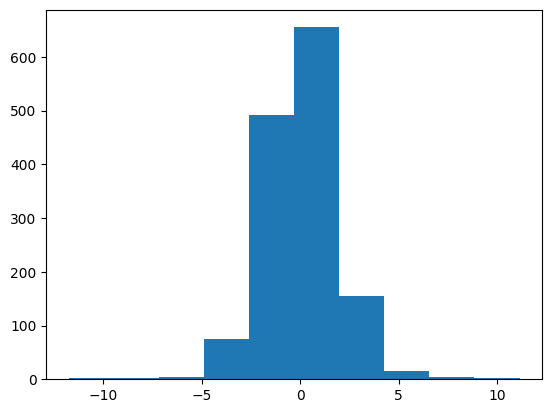

In [138]:
plt.hist(b)
plt.show() 

In [61]:
diff_mm_list = []
for study in studies:
    united_t1 = study.serieses_united['Sagittal T1']
    if united_t1:
        if not any(united_t1.error_codes.values()):
            level = united_t1.levels[4]
            l1_l2_diff =np.multiply(np.array(united_t1.levels[2].condition("Left Neural Foraminal Narrowing").location) - np.array(united_t1.levels[1].condition("Left Neural Foraminal Narrowing").location),level.pixel_spacing)
            diff = np.multiply(np.array(level.condition("Left Neural Foraminal Narrowing").location) - np.array(level.condition("Right Neural Foraminal Narrowing").location),level.pixel_spacing)/np.array([l1_l2_diff[1], l1_l2_diff[1]])
            diff_mm_list.append(diff)

In [320]:
a = np.stack(diff_mm_list, axis=0)[:,0]
b = np.stack(diff_mm_list, axis=0)[:,1]

In [321]:
[[0.4561743289027091, 6.853972053323634], [1.6225195295453767, 7.77356930347386], [3.839385003871206, 7.376603897798195], [8.392937974610055, 6.544874011053045], [12.65899050659098, 2.265362687601025]]

[[0.4561743289027091, 6.853972053323634],
 [1.6225195295453767, 7.77356930347386],
 [3.839385003871206, 7.376603897798195],
 [8.392937974610055, 6.544874011053045],
 [12.65899050659098, 2.265362687601025]]

In [322]:
# LV1
# mean x diff 0.4561743289027091
# mean y diff 6.853972053323634
#LV 2 
# x 1.6225195295453767
# y 7.77356930347386
#LV 3
# x 3.839385003871206
# y 7.376603897798195
#LV 4
# 8.392937974610055
# 6.544874011053045
# LV5
# 12.65899050659098
# 2.265362687601025

level 1: -0.35106274470425297 : -0.07095016560527388 mean=-0.21564380733758998  
level 2: -0.3993192719116642 : -0.0862481512107329 mean=-0.2458177650969595  
level 3: -0.3897499288836156: -0.0725476596076427 mean = -0.23590729285414505  
level 4: -0.37042972279778974: -0.03889105325878629 mean = -0.20832391241117465  
level 5: -0.2563927118725719: 0.11252887230881617 mean = -0.07139008364561858

w_lokup = {'L1/L2': [-0.139229420651575, 0.12529470790146413],
'L2/L3': [-0.18862388100873442, 0.08703452836431066],
'L3/L4': [-0.26101392262684364, 0.01631277635712034],
'L4/L5': [-0.42527738915462654, -0.10961258011935036],
'L5/S1': [-0.5523124287992165, -0.24461601730367605],
}  
1: -0.008815970509666681  
2: -0.04940920062297069  
3: -0.11946353734773281  
4: -0.25816770025787367
4: -0.38903150361420064

w_lokup_f_to_f = 
{'L1/L2': [-0.15, 0.15],
'L2/L3': [0.15, 0.15],
'L3/L4': [0.15, 0.15],
'L4/L5': [0.15, 0.15],
'L5/S1': [-0.5523124287992165, -0.24461601730367605],
}  
h_lokup_f_to_f = 
{'L1/L2': [0.15, 0.15],
'L2/L3': [0.15, 0.2],
'L3/L4': [0.15, 0.2],
'L4/L5': [0.15, 0.15],
'L5/S1': [-0.5523124287992165, -0.24461601730367605],
}  

In [323]:
print(np.mean(a))
print(np.percentile(b, 95))
print(np.percentile(b, 5))

0.002548099270093148
0.11712781914283932
-0.13187908191687642


In [290]:
np.percentile(b, 50) 

-0.007447931852220512

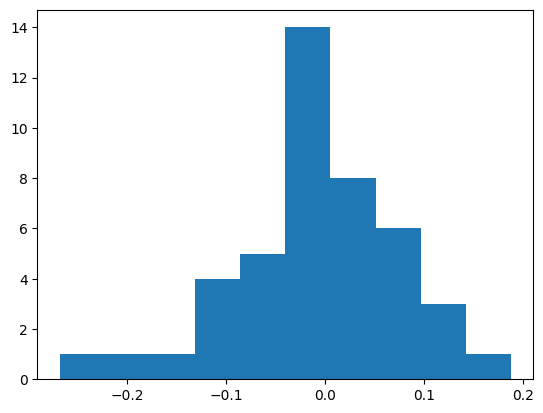

In [292]:
plt.hist(b)
plt.show() 

In [131]:
a.serieses_united['Sagittal T2/STIR'].create_levels_boxes(1/4)

In [190]:
a.serieses['Sagittal T1'].show_series("/workspaces/RSNA_LSDC/inputs/dataset")

In [38]:
"Level {3}: " + '\n' + "kooo"

'Level 3: \nkooo'

In [120]:
for study in coordinates_data.study_id.unique():
    cs = coordinates_data[coordinates_data['study_id']==study]
    if len(cs[cs['series_description']=='Sagittal T1'].series_id.unique())>1:
        print(study)
#coordinates_data[coordinates_data[]]

490052995
1261271580
2507107985
2626030939
2773343225
3109648055
3387993595


In [279]:
coordinates_data[coordinates_data.study_id == 2626030939].head(30)

study_id   series_id  level instance_number  \
18293  2626030939   486328892  L1/L2            [11]   
18294  2626030939   486328892  L2/L3            [11]   
18295  2626030939   486328892  L3/L4            [11]   
18296  2626030939   486328892  L4/L5            [11]   
18297  2626030939   486328892  L5/S1            [11]   
18298  2626030939   956892659  L1/L2             [7]   
18299  2626030939   956892659  L2/L3             [7]   
18300  2626030939   956892659  L3/L4             [7]   
18301  2626030939   956892659  L4/L5             [7]   
18302  2626030939   956892659  L5/S1             [7]   
18303  2626030939  1515032584  L1/L2            [11]   
18304  2626030939  1515032584  L2/L3            [11]   
18305  2626030939  1515032584  L3/L4            [11]   
18306  2626030939  1515032584  L4/L5            [11]   
18307  2626030939  1515032584  L5/S1            [11]   
18308  2626030939  2259927996  L1/L2          [9, 8]   
18309  2626030939  2259927996  L2/L3        [15, 15]   
18310  2626030939  2811693397  L3/L4          [6, 6]   
18311  2626030939  2811693397  L4/L5        [12, 12]   
18312  2626030939  2811693397  L5/S1        [18, 18]   

                                               condition  \
18293                  [Left Neural Foraminal Narrowing]   
18294                  [Left Neural Foraminal Narrowing]   
18295                  [Left Neural Foraminal Narrowing]   
18296                  [Left Neural Foraminal Narrowing]   
18297                  [Left Neural Foraminal Narrowing]   
18298                            [Spinal Canal Stenosis]   
18299                            [Spinal Canal Stenosis]   
18300                            [Spinal Canal Stenosis]   
18301                            [Spinal Canal Stenosis]   
18302                            [Spinal Canal Stenosis]   
18303                 [Right Neural Foraminal Narrowing]   
18304                 [Right Neural Foraminal Narrowing]   
18305                 [Right Neural Foraminal Narrowing]   
18306                 [Right Neural Foraminal Narrowing]   
18307                 [Right Neural Foraminal Narrowing]   
18308  [Right Subarticular Stenosis, Left Subarticula...   
18309  [Right Subarticular Stenosis, Left Subarticula...   
18310  [Right Subarticular Stenosis, Left Subarticula...   
18311  [Right Subarticular Stenosis, Left Subarticula...   
18312  [Right Subarticular Stenosis, Left Subarticula...   

                                              x  \
18293                       [328.7732115677321]   
18294                      [316.30441400304414]   
18295                      [310.07001522070016]   
18296                      [307.73211567732113]   
18297                      [316.30441400304414]   
18298                      [323.69675090252707]   
18299                      [316.30324909747293]   
18300                       [317.2274368231047]   
18301                       [326.4693140794224]   
18302                       [340.3321299638989]   
18303                       [326.3786982248521]   
18304                      [316.78500986193296]   
18305                      [306.68639053254435]   
18306                       [310.7258382642998]   
18307                       [318.8047337278106]   
18308  [219.24198250728864, 275.13155976676387]   
18309    [225.2128279883382, 278.8633381924198]   
18310   [237.1545189504373, 285.58053935860056]   
18311    [230.43731778425652, 283.341472303207]   
18312   [228.19825072886297, 280.3560495626822]   

                                              y                      status  \
18293                      [134.81887366818873]               [Normal/Mild]   
18294                       [195.6042617960426]               [Normal/Mild]   
18295                       [258.7275494672755]               [Normal/Mild]   
18296                       [314.0578386605784]               [Normal/Mild]   
18297                       [379.5190258751903]               [Normal/Mild]   
18298                    

In [10]:
# find only fully annoted samples
data_axial = data_axial[(data_axial.wrong_annotation == 0) & (data_axial.wrong_annotation == 0) & (data_axial.wrong_annotation == 0)]
print(len(data_axial.index))
data_axial.head()

10463


study_id   series_id  level       instance_number  \
0   4003253  2448190387  L1/L2       [4, 3, 4, 2, 2]   
1   4003253  2448190387  L2/L3   [11, 11, 11, 10, 9]   
2   4003253  2448190387  L3/L4  [19, 19, 19, 18, 17]   
3   4003253  2448190387  L4/L5  [28, 28, 28, 27, 27]   
4   4003253  2448190387  L5/S1  [35, 35, 35, 35, 34]   

                                           condition  \
0  [Right Subarticular Stenosis, Left Subarticula...   
1  [Right Subarticular Stenosis, Left Subarticula...   
2  [Right Subarticular Stenosis, Left Subarticula...   
3  [Right Subarticular Stenosis, Left Subarticula...   
4  [Right Subarticular Stenosis, Left Subarticula...   

                                                   x  \
0  [145.28877148997134, 179.12644787644788, 162.2...   
1  [145.9000417860554, 180.9797297297297, 163.439...   
2  [142.84369030563514, 176.0376447876448, 159.44...   
3  [147.4282175262655, 172.9488416988417, 160.188...   
4  [145.9000417860554, 179.7442084942085, 162.822...   

                                                   y  \
0  [158.6246418338109, 161.23552123552125, 168.38...   
1  [157.09646609360075, 158.76447876447878, 166.7...   
2  [156.1795606494747, 157.52895752895753, 165.15...   
3  [158.01337153772684, 156.91119691119692, 163.8...   
4  [161.3753581661891, 161.85328185328186, 170.07...   

                                              status  window_width  \
0  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...         586.0   
1  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...         586.0   
2  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...         586.0   
3  [Normal/Mild, Moderate, Normal/Mild, Moderate,...         586.0   
4  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...         586.0   

   slice_thickness   pixel_spacing  image_width  image_height  \
0              4.0  [0.625, 0.625]          320           320   
1              4.0  [0.625, 0.625]          320           320   
2              4.0  [0.625, 0.625]          320           320   
3              4.0  [0.625, 0.625]          320           320   
4              4.0  [0.625, 0.625]          320           320   

                                   present_instances  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                     slice_locations series_description  \
0  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   
1  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   
2  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   
3  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   
4  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   

   wrong_annotation  mismatched  no_t2  
0               0.0         0.0    0.0  
1               0.0         0.0    0.0  
2               0.0         0.0    0.0  
3               0.0         0.0    0.0  
4               0.0         0.0    0.0

In [9]:
data_axial[data_axial.study_id == 40745534].head()

study_id   series_id  level       instance_number  \
79  40745534  1395478236  L1/L2  [18, 18, 18, 18, 18]   
80  40745534  1395478236  L2/L3  [26, 25, 26, 26, 26]   
81  40745534  1395478236  L3/L4  [34, 34, 34, 34, 34]   
82  40745534  1395478236  L4/L5  [44, 43, 44, 44, 44]   
83  40745534  1395478236  L5/S1  [53, 52, 53, 46, 46]   

                                            condition  \
79  [Right Subarticular Stenosis, Left Subarticula...   
80  [Right Subarticular Stenosis, Left Subarticula...   
81  [Right Subarticular Stenosis, Left Subarticula...   
82  [Right Subarticular Stenosis, Left Subarticula...   
83  [Right Subarticular Stenosis, Left Subarticula...   

                                                    x  \
79  [145.67047817047816, 182.37288135593215, 164.0...   
80  [137.6871101871102, 177.6271186440678, 157.657...   
81  [141.67879417879416, 171.20217934301343, 156.4...   
82  [151.65800415800416, 170.33898305084745, 160.9...   
83  [150.99272349272348, 178.3050847457627, 164.64...   

                                                    y  \
79  [174.63617463617464, 172.20338983050846, 182.5...   
80  [170.64449064449065, 169.32203389830508, 179.9...   
81  [167.98336798336797, 168.14463573391154, 175.4...   
82  [167.98336798336797, 167.45762711864407, 172.3...   
83  [163.991683991684, 164.91525423728814, 171.281...   

                                               status  window_width  \
79  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...        1147.0   
80  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...        1147.0   
81  [Moderate, Moderate, Moderate, Normal/Mild, No...        1147.0   
82       [Severe, Severe, Severe, Moderate, Moderate]        1147.0   
83  [Normal/Mild, Moderate, Normal/Mild, Moderate,...        1147.0   

    slice_thickness pixel_spacing  image_width  image_height  \
79              3.5    [0.5, 0.5]          320           320   
80              3.5    [0.5, 0.5]          320           320   
81              3.5    [0.5, 0.5]          320           320   
82              3.5    [0.5, 0.5]          320           320   
83              3.5    [0.5, 0.5]          320           320   

                                    present_instances  \
79  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
80  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
81  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
82  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
83  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                      slice_locations series_description  \
79  [-360.57311168613, -364.07311065141, -367.5731...           Axial T2   
80  [-360.57311168613, -364.07311065141, -367.5731...           Axial T2   
81  [-360.57311168613, -364.07311065141, -367.5731...           Axial T2   
82  [-360.57311168613, -364.07311065141, -367.5731...           Axial T2   
83  [-360.57311168613, -364.07311065141, -367.5731...           Axial T2   

    wrong_annotation  mismatched  no_t2  
79               0.0         1.0    0.0  
80               0.0         1.0    0.0  
81               0.0         1.0    0.0  
82               0.0         1.0    0.0  
83               0.0         1.0    0.0

In [12]:
data_axial.to_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_unified_axial_full.pkl")

In [25]:
box_data = []
abox_data = []
for series in data_axial.series_id.unique():
    all_x = []
    all_y = []
    for ind, row in data_axial[data_axial.series_id == series].iterrows():
        all_x += row.x
        all_y += row.y
        box_data.append({'study_id':row.study_id,
                    'series_id':row.series_id,
                    'level': row.level,
                    'type': 'pascal_voc',
                    'box': [min(row.x), min(row.y), max(row.x), max(row.y)]})
        
    abox_data.append({
        'study_id':row.study_id, 
        'series_id':row.series_id,
        'abox': [min(all_x), min(all_y), max(all_x), max(all_y)]})
    
    

In [26]:
data_axial = data_axial.merge(pd.DataFrame(box_data), on=['study_id', 'series_id', 'level'])
data_axial = data_axial.merge(pd.DataFrame(abox_data), on=['study_id', 'series_id'])
data_axial.head()

study_id   series_id  level       instance_number  \
0   4003253  2448190387  L1/L2       [4, 3, 4, 2, 2]   
1   4003253  2448190387  L2/L3   [11, 11, 11, 10, 9]   
2   4003253  2448190387  L3/L4  [19, 19, 19, 18, 17]   
3   4003253  2448190387  L4/L5  [28, 28, 28, 27, 27]   
4   4003253  2448190387  L5/S1  [35, 35, 35, 35, 34]   

                                           condition  \
0  [Right Subarticular Stenosis, Left Subarticula...   
1  [Right Subarticular Stenosis, Left Subarticula...   
2  [Right Subarticular Stenosis, Left Subarticula...   
3  [Right Subarticular Stenosis, Left Subarticula...   
4  [Right Subarticular Stenosis, Left Subarticula...   

                                                   x  \
0  [145.28877148997134, 179.12644787644788, 162.2...   
1  [145.9000417860554, 180.9797297297297, 163.439...   
2  [142.84369030563514, 176.0376447876448, 159.44...   
3  [147.4282175262655, 172.9488416988417, 160.188...   
4  [145.9000417860554, 179.7442084942085, 162.822...   

                                                   y  \
0  [158.6246418338109, 161.23552123552125, 168.38...   
1  [157.09646609360075, 158.76447876447878, 166.7...   
2  [156.1795606494747, 157.52895752895753, 165.15...   
3  [158.01337153772684, 156.91119691119692, 163.8...   
4  [161.3753581661891, 161.85328185328186, 170.07...   

                                              status  window_width  \
0  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...         586.0   
1  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...         586.0   
2  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...         586.0   
3  [Normal/Mild, Moderate, Normal/Mild, Moderate,...         586.0   
4  [Normal/Mild, Normal/Mild, Normal/Mild, Normal...         586.0   

   slice_thickness   pixel_spacing  image_width  image_height  \
0              4.0  [0.625, 0.625]          320           320   
1              4.0  [0.625, 0.625]          320           320   
2              4.0  [0.625, 0.625]          320           320   
3              4.0  [0.625, 0.625]          320           320   
4              4.0  [0.625, 0.625]          320           320   

                                   present_instances  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                     slice_locations series_description  \
0  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   
1  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   
2  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   
3  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   
4  [-376.11313, -380.51312, -384.91312, -389.3131...           Axial T2   

         type                                                box  \
0  pascal_voc  [145.28877148997134, 158.6246418338109, 185.24...   
1  pascal_voc  [145.9000417860554, 157.09646609360075, 194.15...   
2  pascal_voc  [136.40066722664, 156.1795606494747, 190.16066...   
3  pascal_voc  [129.46853089255362, 145.50400405882593, 183.2...   
4  pascal_voc  [132.10212642013195, 151.3891263590715, 185.86...   

                                                abox  
0  [129.46853089255362, 145.50400405882593, 194.1...  
1  [129.46853089255362, 145.50400405882593, 194.1...  
2  [129.46853089255362, 145.50400405882593, 194.1...  
3  [129.46853089255362, 145.50400405882593, 194.1...  
4  [129.46853089255362, 145.50400405882593, 194.1...

In [27]:
data_axial.to_pickle("/workspaces/RSNA_LSDC/inputs/box_data/box_info_axial.pkl")

# Prepare boxes sagittal
For sagittal: we'll be doing tests later. For now we have plans to use the points to create 'level' regions which would contain all necesaryy condition inside said region.

In [ ]:
data_sagittal_t1=pd.read_pickle("/workspaces/RSNA_LSDC/inputs/box_data/coordinates/coordinates_unified_sagittal_t1.pkl")
print(len(data_sagittal_t1.index))
data_sagittal_t1.head()

In [ ]:
class Levelsagittal():
    def __init__(self, level:pd.DataFrame):
        
        self.im_width = level.iloc[0].image_width
        self.im_height = level.iloc[0].image_height

        self.level_ind = level.iloc[0].level
        self.instances = None
        self.level_boundaries = [] # y_min and y_max for each level

        self.conditions  = self.get_conditions(level)
        #self.depths = None
        self.fully_annoted = (len(self.conditions)==5)
        self.fully_valid = (sum([i.valid for i in self.conditions])==5)
        self.level_box = None
        self.create_level_box()

    def get_conditions(self, level:pd.DataFrame):
        present_conditions = []
        present_instances = []

        cond = level.explode(['instance_number','condition','x','y','status'])
        for i, condition in cond.iterrows():
            present_instances.append(condition.instance_number)
            present_conditions.append(Condition(condition.condition,
                                                condition.status,
                                                (condition.x, condition.y),
                                                condition.instance_number,
                                                True))
            
        self.instances = list(range(min(present_instances), max(present_instances)+1))
        self.depths = [level.iloc[0].slice_locations[level.iloc[0].present_instances.index(instance)] for instance in self.instances]
        return present_conditions
    
    def get_level_box(self, overhead:float = 0.0)->list[int]:
        instance_boxes = np.stack([condition.location for condition in self.conditions], axis = 0)
        return [max(0, min(instance_boxes[0,:]- overhead)), 
                self.level_boundaries[0], 
                min(self.im_width, max(instance_boxes[0,:])+overhead), 
                min(self.im_height, self.level_boundaries[1])]
    
    def visible_conditions(self)->list[str]:
        return([condition.condition_name for condition in self.conditions])

In [ ]:
            for level_t1, level_t2, level_t1_u, level_t2_u in zip(self.serieses['Sagittal T1'].levels, self.serieses['Sagittal T2/STIR'].levels,  
                                                                  self.serieses_united['Sagittal T1'].levels, self.serieses_united['Sagittal T2/STIR'].levels):
                if level_t1 and level_t2:
                    level_t1_u.united = True
                    level_t2_u.united = True
                    t2_to_t1_added = level_t1_u.add_conditions_from_level(level_t2, try_fix = try_fix)
                    if not t2_to_t1_added:
                        self.study_logs.append(f"Adding T1 and T2 levels: {level_t1.level_ind} ended in faliure. Reason: Mismatch.")
                        mismatch_t1.append(True)
                        mismatch_t2.append(True)
                        if try_fix:
                            level_t1_u.fix_coordinates(self.dataset_path)
                            level_t1_u.get_instances()
                            level_t1_u.create_instance_box()
                            level_t1_u.diagnose_level()
                            
                            self.study_logs.append(f"Mismatch resolved by user.")
                            level_t1_u.fix_codes['user fixed'] = True
                            self.serieses_united['Sagittal T1'].fix_codes['user fixed'] = True
                            t1_to_t2_added = level_t2_u.add_conditions_from_level_united(level_t1_u)
                            mismatch_t1[-1] = False
                            if t1_to_t2_added:
                                level_t2_u.fix_codes['user fixed'] = True
                                self.serieses_united['Sagittal T2/STIR'].fix_codes['user fixed'] = True
                                mismatch_t2[-1] = False
                            else:
                                self.study_logs.append(f"Mismatch preserved for united T2 series.") 
                    else:
                        mismatch_t1.append(False)
                        mismatch_t2.append(False)
                        t1_to_t2_added = level_t2_u.add_conditions_from_level(level_t1, try_fix=False)

In [27]:
import cv2
img = cv2.imread('/workspaces/RSNA_LSDC/inputs/dataset/4003253/702807833/1.png') # load a dummy image
while(1):
    cv2.imshow('img',img)
    k = cv2.waitKey(33)
    if k==27:    # Esc key to stop
        break
    elif k==-1:  # normally -1 returned,so don't print it
        continue
    else:
        print(k) # else print its value


32
32
32
32
32
32
32


KeyboardInterrupt: 

In [22]:
cv2.destroyAllWindows()

In [ ]:
                #t1_to_t2_added = level_t2_u.add_conditions_from_level_united(level_t1_u)
                elif level_t1 and level_t2 is None:
                    self.study_logs.append(f"Adding series data for levels: {level_t1.level_ind} ended in faliure. Reason: Missing T2 level.")
                    self.serieses_united['Sagittal T1'].levels[self.serieses_united['Sagittal T1'].level_names[level_t1.level_ind]] = None
                    self.serieses_united['Sagittal T1'].diagnose_series()
                elif level_t1 is None and level_t2:
                    self.study_logs.append(f"Adding series data for levels: {level_t2.level_ind} ended in faliure. Reason: Missing T1 level.")
                    self.serieses_united['Sagittal T2/STIR'].levels[self.serieses_united['Sagittal T2/STIR'].level_names[level_t2.level_ind]] = None
                    self.serieses_united['Sagittal T2/STIR'].diagnose_series()
                elif level_t1 is None and level_t2 is None:
                    self.study_logs.append(f"Adding series data ended in faliure. Reason: Missing both T1 and T2 levels.")